# Estimating error prediction (on-the-fly)

In this experiment we will try to estimate the errors in the predictions of a neural network based on a synthetic dataset.

## List of experiments
1. [Original experiment](#experiment-original)
1. [Minibatches](#experiment-minibatches)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


from utils.tf import train  # Train outside the keras framework

In [2]:
# Constants
SEED = 42  # Reproducibility

plt.rcParams["figure.figsize"]=20,10

In [3]:
tf.random.set_seed(SEED)
np.random.seed(SEED)
experiments = {}  # Where experiments will be stored

## Utils
Maybe this should go in a library.

In [4]:
def f_gen_data(x, f_x2y, f_noise, *args, **kwargs):
    """Generate samples and labels for train and test.
    
    PARAMETERS
    ----------
    x: list of inputs x samples x dim of the input 
        Samples.
    f_x2y: function(x)-> y
        y is a list of outputs x samples x dim of the output
    f_noise: function(x) -> noise to add to y
        Function that generates noise for the outputs.

    RETURN
    ------
    y: list of outputs with noise.
    """    
    return [y+noise for y, noise in zip(f_x2y(x), f_noise(x))]

In [5]:
def plot_predictions(x, y_pred, y_uncertainty, y_true):
    """Plot fit and uncertainty"""
    plt.errorbar(x[0], y_pred, yerr=y_uncertainty, fmt='.', color='green', alpha=0.01, label="uncertainty")
    plt.plot(x[0], y_true[0], '.', color='blue', alpha=0.1, label="truth")
    plt.plot(x[0], y_pred, '.', color='black', alpha=0.05, label="predicted")
    plt.title("Predictions")
    plt.grid()
    plt.xlabel("x");
    plt.ylabel("y");
    plt.legend()
    plt.show()
    

def plot_uncertainty(x, y_uncertainty, f_uncertainty):
    """Plot captured uncertainty."""
    plt.plot(x[0], f_uncertainty(x)[0], '.', color='black', alpha=0.05, label="truth")
    plt.plot(x[0], y_uncertainty, '.', color='green', alpha=0.5, label="predicted")
    plt.title("Captured uncertainty")
    plt.grid()
    plt.xlabel("x")
    plt.ylabel("Uncertainty")
    plt.legend()
    plt.show()


def print_metrics(model, loss, true_x, true_y, f_uncertainty):
    pred = model.predict(true_x)
    print("Loss: {}".format(loss(true_y, pred)))
    plot_predictions(
        x=true_x,
        y_pred=pred[0],
        y_uncertainty=pred[1]*3, # 3 std deviations captures 99.7% of samples, conservative margin
        y_true=true_y
    )
    plot_uncertainty(
        x=true_x,
        y_uncertainty=pred[1],
        f_uncertainty=f_uncertainty
    )

---

In [6]:
experiments = dict()  # To save all the data from the experiments

## Original experiment <a name="experiment-original"></a>

In this experiment we will try to measure the uncertainty in the predictions of a machine learning model.

The experiment is based on the work of Steve Thorn. The idea is to add an output, to a neural network, that gives an estimation of the uncertainty of the prediction.

In [7]:
# Here I will save the data for the original experiment
experiments['original'] = {
    'name': '01-original'
}

experiment = experiments['original']

### Generate a synthetic dataset

Using a synthetic dataset is useful since we can fully control the data generation phenomenon. This way we can test the potentiality of the method.

Dataset properties:

* $x \in \mathbb{R} \in  [0,1)$.  Sampled from a [uniform distribution](https://en.wikipedia.org/wiki/Uniform_distribution_%28continuous%29) $\mathcal{U}(0,1)$.
* $y \in \mathbb{R} $

The relationship is $y = 2x+1$

In [8]:
def relationship_01(x):
    return [2*x[0] + 1]

This is our synthetic data without noise.

In [9]:
def gen_x_01(n_samples):
    return [
        tf.random.uniform(
            shape=(n_samples,1),
            minval=0.0,
            maxval=1.0
        )
    ]

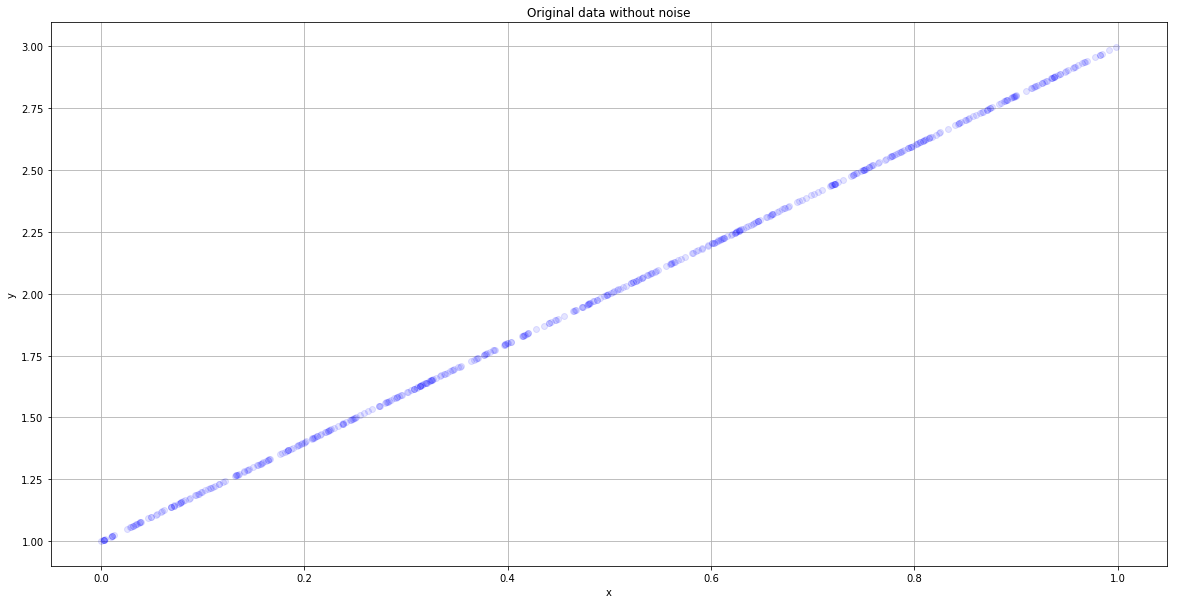

In [10]:
x = gen_x_01(500)

plt.plot( x[0], relationship_01(x)[0], 'o', color='blue', alpha=0.1)
plt.title("Original data without noise")
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

#### Adding uncertainty

Since the previous relationship is easily captured by a linear model (i.e. a linear regression), we will add some noise to add uncertainty in the predictions.

The noise is sampled from a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) with a mean of $0$ and a standard deviation of $1$.

That is $\mathcal{N}(\mu=0.0,\sigma=1.0)$


##### Heteroscedasticity
The problem with this noise is that is equally distributed along the dataset. So the prediction error will be homogeneus, it fullfils the assumption of [homoscedasticity](https://en.wikipedia.org/wiki/Homoscedasticity) and the uncertainty could also be measured with a simple linear regression.

So in order to make the error ($\varepsilon$) difficult to measure we will make it dependant on the $x$ value in a periodic manner.

$\varepsilon = \mathcal{N}(\mu=0.0, \sigma=\left| \sin(4*\pi*x) \right| * 0.4)$

Factors explanation
* 4$\pi$ means 4 repetitions per unit in $x$.
* 0.4 is the maximum value the standard deviation will have.

This is how the standard deviation changes depending on the feature (x).

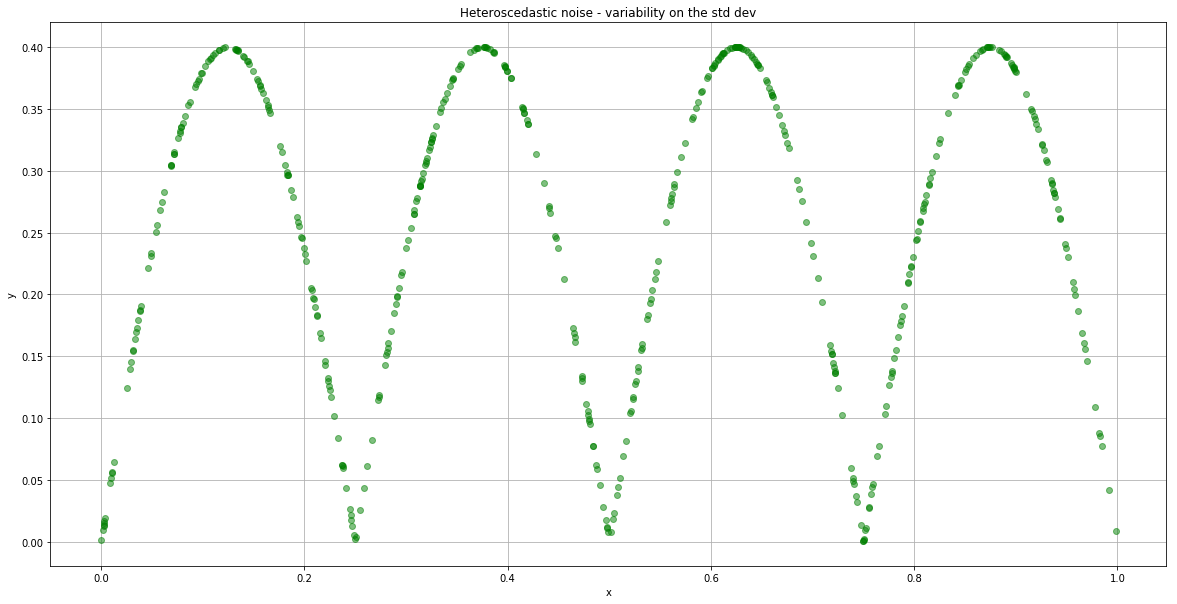

In [11]:
# View the period on the std dev of the noise

def gen_stdev_01(x):
    return [(np.abs(np.sin(x[0] * 4 * np.pi)) * 0.4)]


plt.plot(x[0], gen_stdev_01(x)[0], 'o', color='green', alpha=0.5)
plt.title("Heteroscedastic noise - variability on the std dev")
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

##### Considerations
1. Every time we sample from the same $x$, there will be different a different $y$.
1. The error is periodic, not completely [stochastic](https://en.wikipedia.org/wiki/Stochastic).
1. If we make a histogram with $y$ values sampled from a fixed $x$ it will be a normal distribution centered on the true value of $x$. The problem is equivalent to fitting infinite normal distributions (one per point) $\mathcal{N}(\mu=\hat{y}, \sigma=uncertainty)$

#### Generate the data

In [12]:
def f_noise_gaussian_periodic_01(x):
    """Generate noise for labels
    
    RETURN: 
     Tuple of tuples (noise for outputs)
    """
    noise = tf.random.normal(
        shape=x[0].shape,
        mean=0.0,
        stddev=gen_stdev_01(x)[0]
    )
    return([noise])

In [13]:
experiment['data'] = {
    'n_train': 10000,
    'n_test': 2000,
    'f_gen_x': gen_x_01,
    'f_x2y': relationship_01,
    'f_noise': f_noise_gaussian_periodic_01
}

In [14]:
train_x = experiment['data']['f_gen_x'](experiment['data']['n_train'])
train_y = f_gen_data(
    x=train_x,
    f_x2y=experiment['data']['f_x2y'],
    f_noise=experiment['data']['f_noise']
)

test_x = experiment['data']['f_gen_x'](experiment['data']['n_test'])
test_y = f_gen_data(
    x=test_x,
    f_x2y=experiment['data']['f_x2y'],
    f_noise=experiment['data']['f_noise']
)

#### Visualize the data

The blue dots are training data, and the red dots are testing data, we see they come from the same population.

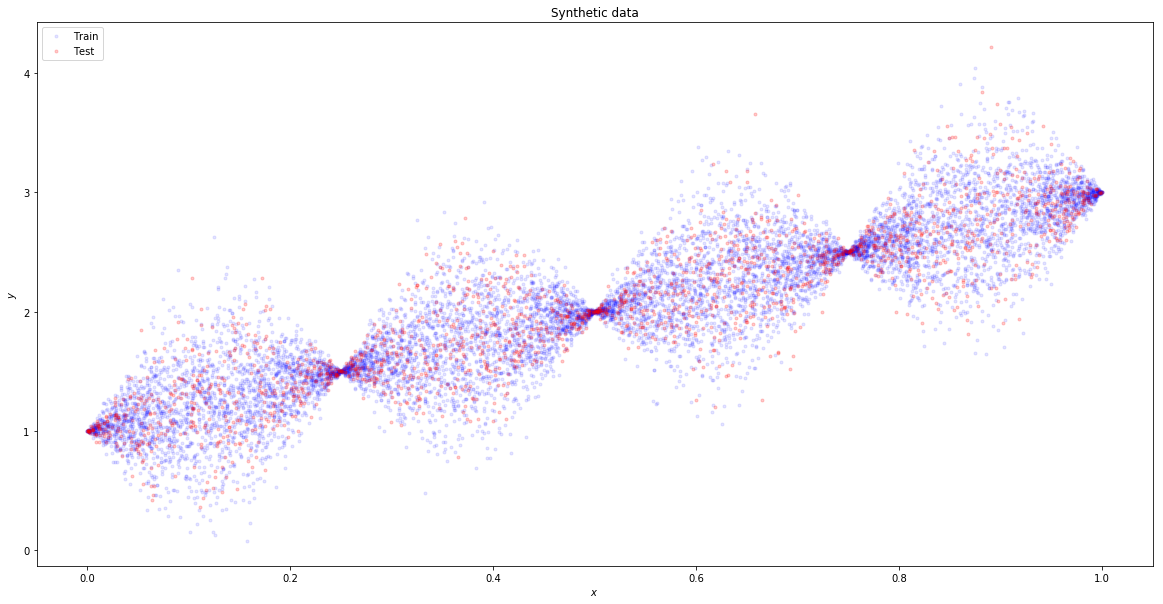

In [15]:
plt.plot(train_x[0], train_y[0], '.', color='blue', label='Train', alpha=0.1)
plt.plot(test_x[0], test_y[0], '.', color='red', label='Test', alpha=0.2)
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.legend(loc='upper left', )
plt.title('Synthetic data')
plt.show()

### Model

The candidate model is an [ANN](https://en.wikipedia.org/wiki/Artificial_neural_network), since it can model non-linearities it should be able to fit an error estimation.

There will be 2 outputs.
* y_pred: the prediction $\hat{y}$
* y_stdev: the uncertainty on the prediction, the standard deviation of the error $\sigma$.

#### Definition

In [16]:
def get_model_01():
    in_x = tf.keras.Input(
        shape=(1,),
        name="IN_x"
    )
    f1 = tf.keras.layers.Dense(
        1000,
        name="hidden",
        activation=tf.keras.activations.relu
    )(in_x)
    out_y = tf.keras.layers.Dense(
        1,
        name="OUT_y",
        activation=tf.keras.activations.linear
    )(f1)
    out_stdev = tf.keras.layers.Dense(
        1,
        name="OUT_stdev",
        activation=tf.keras.activations.linear
    )(f1)
    return tf.keras.Model(inputs=[in_x], outputs=[out_y, out_stdev], name="model_01")

In [17]:
experiment['model'] =  get_model_01()
experiment['model'].summary()

Model: "model_01"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
IN_x (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
hidden (Dense)                  (None, 1000)         2000        IN_x[0][0]                       
__________________________________________________________________________________________________
OUT_y (Dense)                   (None, 1)            1001        hidden[0][0]                     
__________________________________________________________________________________________________
OUT_stdev (Dense)               (None, 1)            1001        hidden[0][0]                     
Total params: 4,002
Trainable params: 4,002
Non-trainable params: 0
_______________________

**Note: Overfitting warning**

We have 4002 parameters to fit 10000 data points and the uncertainty in the estimation. Since the relationship is linear $y = ax + b$ (only 2 parameters needed to predict $y$, y_pred), there are 4000 parameters dedicated to the error prediction, that is a rate of 2 free parameters to 5 data points.

#### Loss function - ⚠ tricky part ⚠

The loss function has to take into account:
1. The predicted value $\hat{y}$ or $\hat{\mu}$.
1. The estimation of the prediction error, standard deviation or $\sigma$.

In order to do backpropagation we have to calculate the error on the prediction, a.k.a loss. We will use [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) to get an estimation of the parameters of the normal distribution and [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) as the loss.

There is a consideration. For each batch, the prediction is a batch of ($\mu$, $\sigma$) tuples that belong to different distributions, so we are estimating a distribution based on a single point.

##### Error for $\hat{y}$
The MLE is.
$$
\mu =  \frac{1}{n}\sum^n_{i=1} y_i
$$


As we only have a point per distribution to fit ($n=1$)...
$$
\mu =  y
$$

The estimator is $y$. So the loss  would be:

$$
Loss_y = MSE_y = \frac{1}{n} (y-\hat{y})^2
$$


##### Error for $\hat{\sigma}$
The MLE is.

$$
uncertainty = \sigma = \sqrt{ \frac{1}{n} \sum_{i=1}^n(\hat{y_i}-\mu)^2 }
$$

As we only have a point per distribution to fit ($n=1$)...

$$
\sigma = \sqrt{ (\hat{y}-y)^2 }
$$

The loss for the standard deviation $\sigma$ would be:

$$
Loss_{\sigma} = MSE_{\sigma} = \frac{1}{n}(\sqrt{ (\hat{y}-y)^2 } - \hat{\sigma} )^2
$$



##### Issues
1. In order to perform backpropagation, a loss function [has to return a scalar](https://github.com/tensorflow/tensorflow/blob/v2.2.0/tensorflow/python/keras/engine/training.py#L265). So, we have to combine the two losses somehow. The problem is we don't know if their **magnitudes are the same order**. If this were not the case, one loss could dominate the training process, making the other loss irrelevant until its error is minimized to the same order.

1. Calculating the error on the uncertainty is quirky. As we approximate $\hat{y}$ to $y$, **the standard deviation value changes** in each iteration, thus affecting through its own loss the neurons and therefore affecting the next $\hat{y}$. This could lead to potential convergence problems or oscillations in the loss in the case where $\mu$ and $\sigma$ were antagonic losses in the process.

In [18]:
@tf.function
def loss01(y_true, y_pred):
    """ Naive implementation
    y_pred: [mean (mu), stdev (sigma)]
    """
    y_pred_mean, y_pred_stdev  = y_pred
    y_sqr_err = (y_true-y_pred_mean)**2
    loss_y = tf.reduce_mean(y_sqr_err)
    loss_stdev = tf.reduce_mean( (tf.math.sqrt(y_sqr_err) - y_pred_stdev)**2 )
    return loss_y+loss_stdev

In [19]:
@tf.function
def loss02(y_true, y_pred):
    """ optimized implementation
    y_pred: [mean (mu), stdev (sigma)]
    """
    y_err = y_true-y_pred[0]  
    return tf.reduce_mean(
        y_err**2 +
        (tf.abs(y_err) - y_pred[1])**2
    )

##### Pick the fastest

In [20]:
pred_y = experiment['model'].predict(train_x)

In [21]:
%%timeit -n 5000
loss01(train_y, pred_y)

313 µs ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 5000 loops each)


In [22]:
%%timeit -n 5000
loss02(train_y, pred_y)

321 µs ± 27.2 µs per loop (mean ± std. dev. of 7 runs, 5000 loops each)


In [23]:
experiment['loss'] = loss02  # Faster

##### Tests

In [24]:
# Same number of means as std devs
assert(pred_y[0].shape==pred_y[1].shape)
# Loss functions compute the same value
assert(loss01(train_y, pred_y)-loss02(train_y, pred_y)<0.00001)  # Same value

#### Train the model

In [25]:
experiment['hyper'] = {  # Hyperparameters
    'optimizer': tf.keras.optimizers.Adam(
        learning_rate=1e-4,
    ),
    'bs': experiments['original']['data']['n_train'],  # Whole dataset
    'epochs': 6000
}

##### Classic Keras

**NOTE**

If I try...
```python
experiments['original']['model'].fit(
    x=train_x,
    y=train_y,
    batch_size=experiments['original']['hyper']['bs'],
    epochs=experiments['original']['hyper']['epochs'],
)
```

Keras complains the target shape is not as expected.
```
ValueError: Error when checking model target: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [<tf.Tensor:...
```

`F**k` keras, do the check on the returned value from the loss function!!!! Not on the training data.

*NOTE: the problem is train_y.shape is not the same as the shape from the otput model.*

##### Au naturel

In [26]:
def f_callback_plot(epoch, loss, *args, **kwargs):
    if epoch%100==0:
        tf.print("Epoch: {}\tLoss: {}".format(epoch,loss))
    if epoch%3000==0:
        print_metrics(experiment['model'], experiment['loss'], train_x, train_y, f_uncertainty=gen_stdev_01)
        

Epoch: 0	Loss: 8.494192123413086
Loss: 8.453691482543945


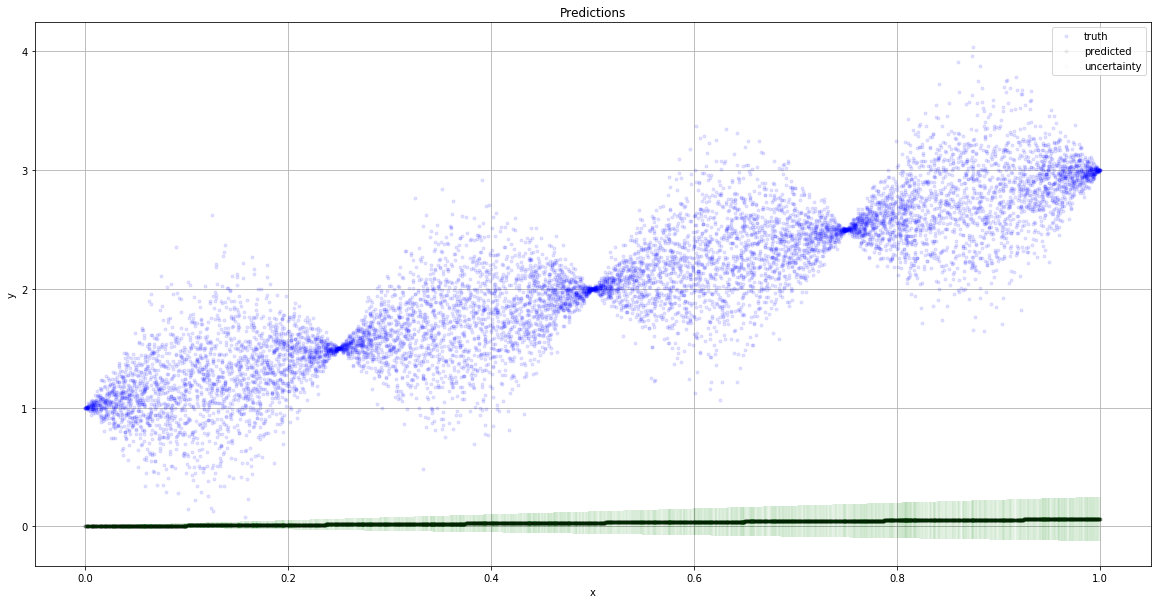

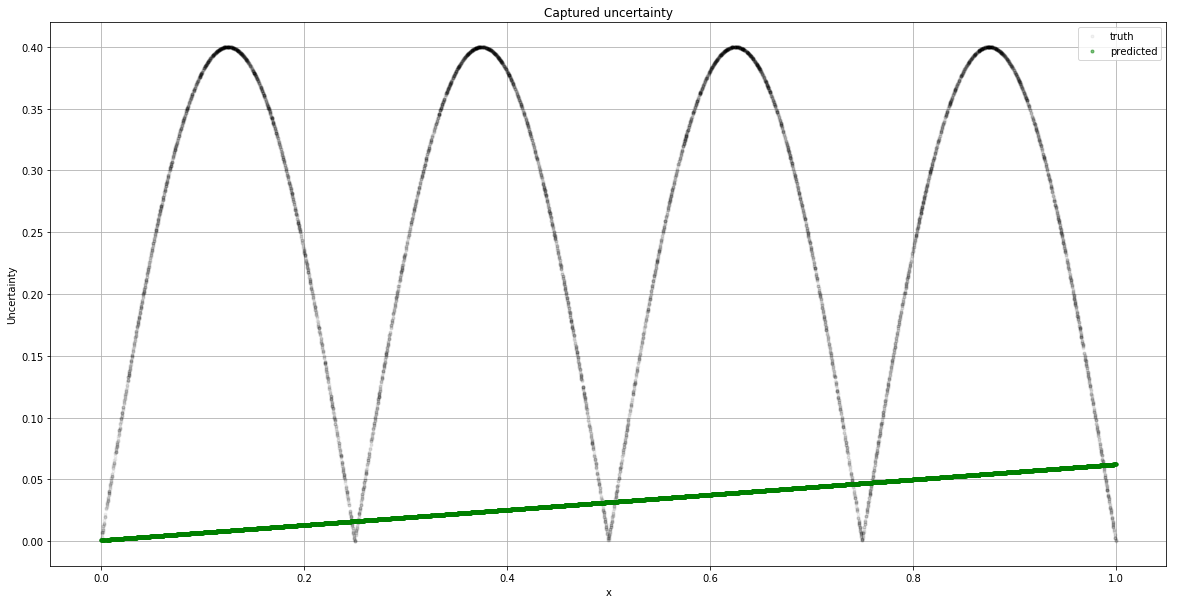

Epoch: 100	Loss: 5.0430521965026855
Epoch: 200	Loss: 2.3872969150543213
Epoch: 300	Loss: 1.0057926177978516
Epoch: 400	Loss: 0.5792240500450134
Epoch: 500	Loss: 0.39694154262542725
Epoch: 600	Loss: 0.2700347900390625
Epoch: 700	Loss: 0.18567655980587006
Epoch: 800	Loss: 0.14413900673389435
Epoch: 900	Loss: 0.13039951026439667
Epoch: 1000	Loss: 0.12749198079109192
Epoch: 1100	Loss: 0.12684594094753265
Epoch: 1200	Loss: 0.1265045553445816
Epoch: 1300	Loss: 0.12619908154010773
Epoch: 1400	Loss: 0.1259021759033203
Epoch: 1500	Loss: 0.12560971081256866
Epoch: 1600	Loss: 0.12532120943069458
Epoch: 1700	Loss: 0.12504130601882935
Epoch: 1800	Loss: 0.12476997077465057
Epoch: 1900	Loss: 0.124508336186409
Epoch: 2000	Loss: 0.12425864487886429
Epoch: 2100	Loss: 0.12401926517486572
Epoch: 2200	Loss: 0.1237901821732521
Epoch: 2300	Loss: 0.1235724464058876
Epoch: 2400	Loss: 0.12336841970682144
Epoch: 2500	Loss: 0.12317871302366257
Epoch: 2600	Loss: 0.123004250228405
Epoch: 2700	Loss: 0.12284472584724

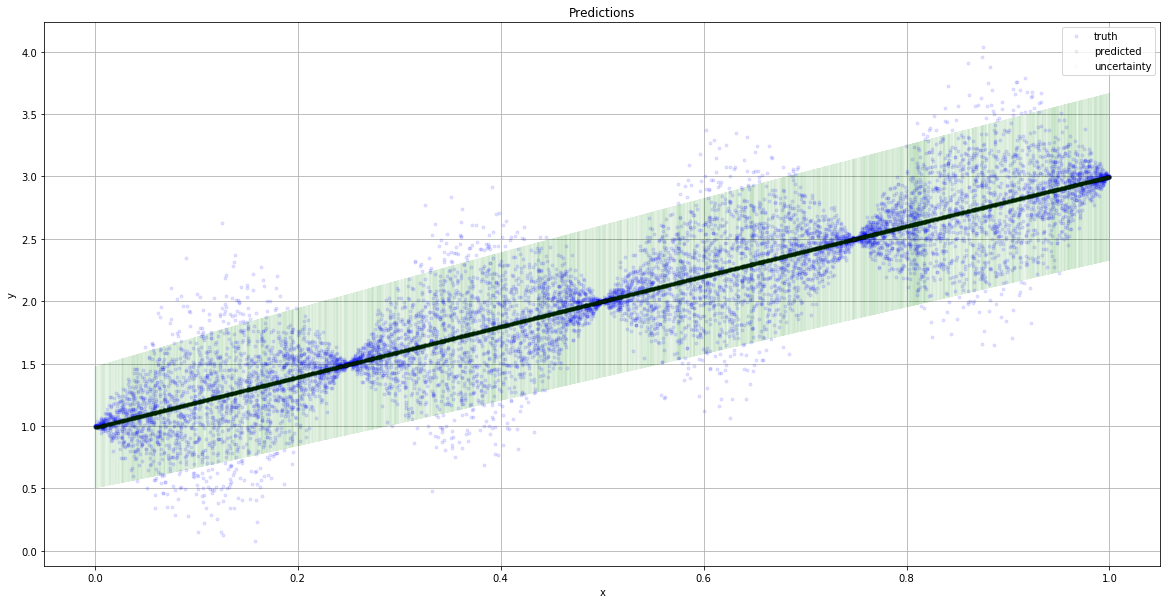

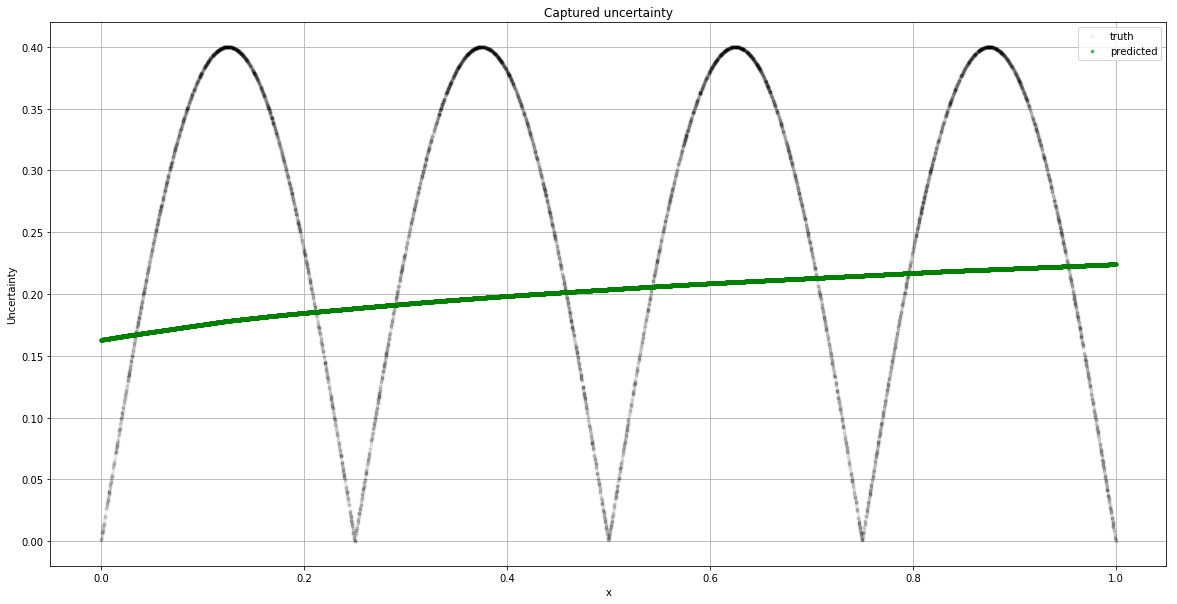

Epoch: 3100	Loss: 0.12234733998775482
Epoch: 3200	Loss: 0.12225089967250824
Epoch: 3300	Loss: 0.1221696063876152
Epoch: 3400	Loss: 0.12210150063037872
Epoch: 3500	Loss: 0.1220451295375824
Epoch: 3600	Loss: 0.12199881672859192
Epoch: 3700	Loss: 0.12196166068315506
Epoch: 3800	Loss: 0.12193211913108826
Epoch: 3900	Loss: 0.12190893292427063
Epoch: 4000	Loss: 0.12189124524593353
Epoch: 4100	Loss: 0.12187810987234116
Epoch: 4200	Loss: 0.12186828255653381
Epoch: 4300	Loss: 0.12186077982187271
Epoch: 4400	Loss: 0.1218552514910698
Epoch: 4500	Loss: 0.12185095250606537
Epoch: 4600	Loss: 0.12184777855873108
Epoch: 4700	Loss: 0.1218450590968132
Epoch: 4800	Loss: 0.12184245884418488
Epoch: 4900	Loss: 0.12184012681245804
Epoch: 5000	Loss: 0.12183842808008194
Epoch: 5100	Loss: 0.12183710932731628
Epoch: 5200	Loss: 0.12183615565299988
Epoch: 5300	Loss: 0.12183544784784317
Epoch: 5400	Loss: 0.12183481454849243
Epoch: 5500	Loss: 0.12183414399623871
Epoch: 5600	Loss: 0.12183351069688797
Epoch: 5700	Loss

In [27]:
train(
    model=experiment['model'],
    f_loss=experiment['loss'],
    optimizer=experiment['hyper']['optimizer'],
    batch_size=experiment['hyper']['bs'],
    epochs=experiment['hyper']['epochs'],
    x_train=train_x,
    y_train=train_y,
    f_callback=f_callback_plot
)

#### Tests

##### Training set

Loss: 0.12183055281639099


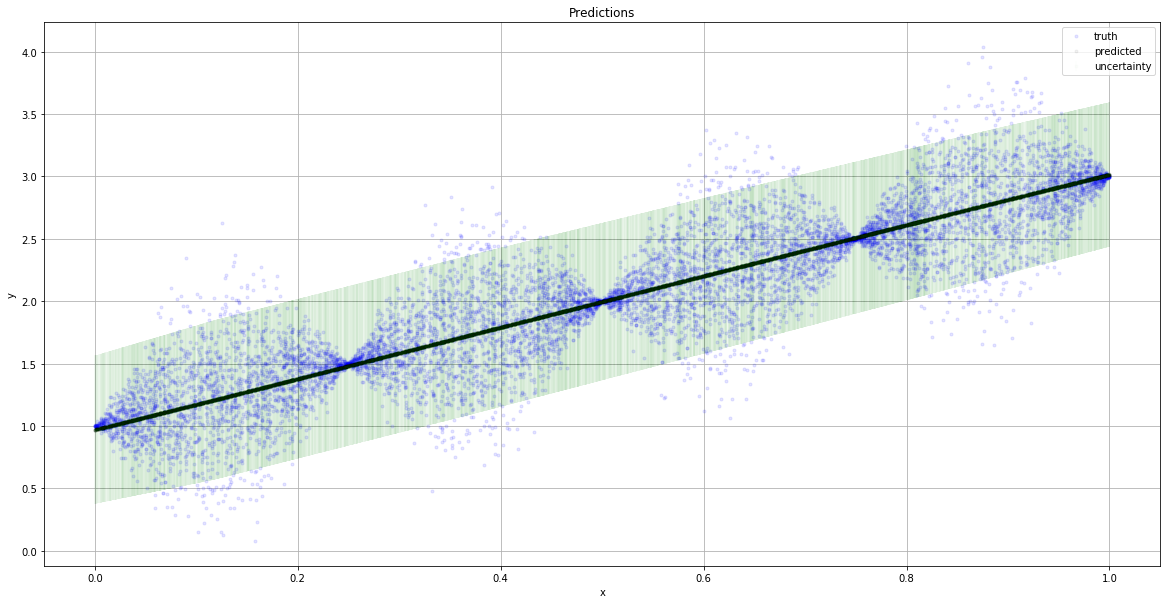

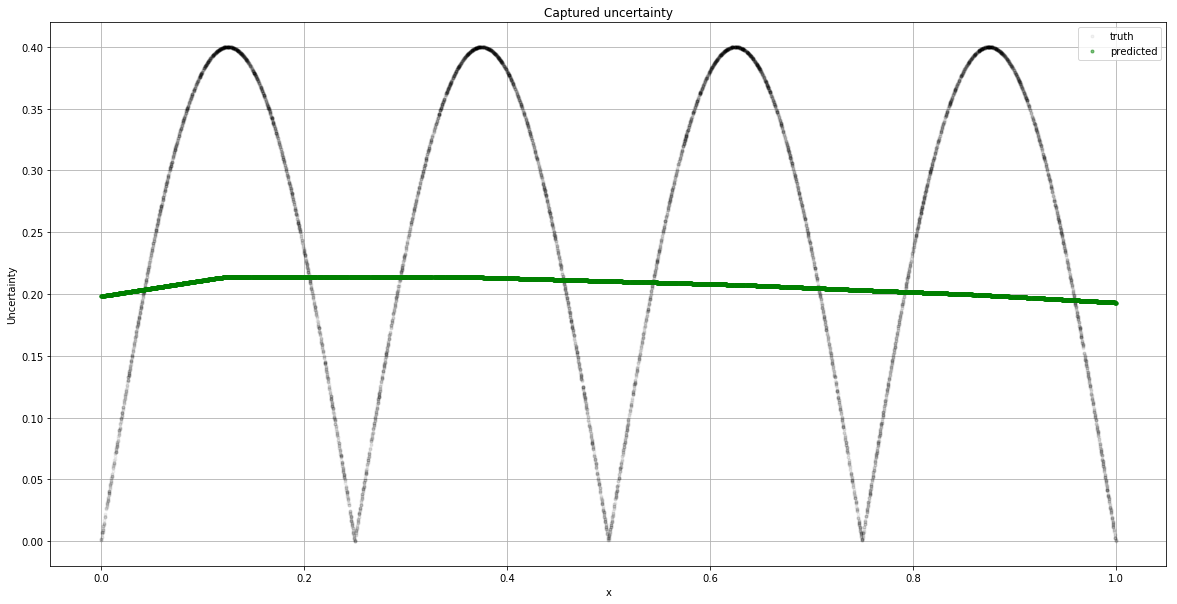

In [29]:
print_metrics(experiment['model'], experiment['loss'], train_x, train_y, f_uncertainty=gen_stdev_01)

##### Testing set

Loss: 0.12209735810756683


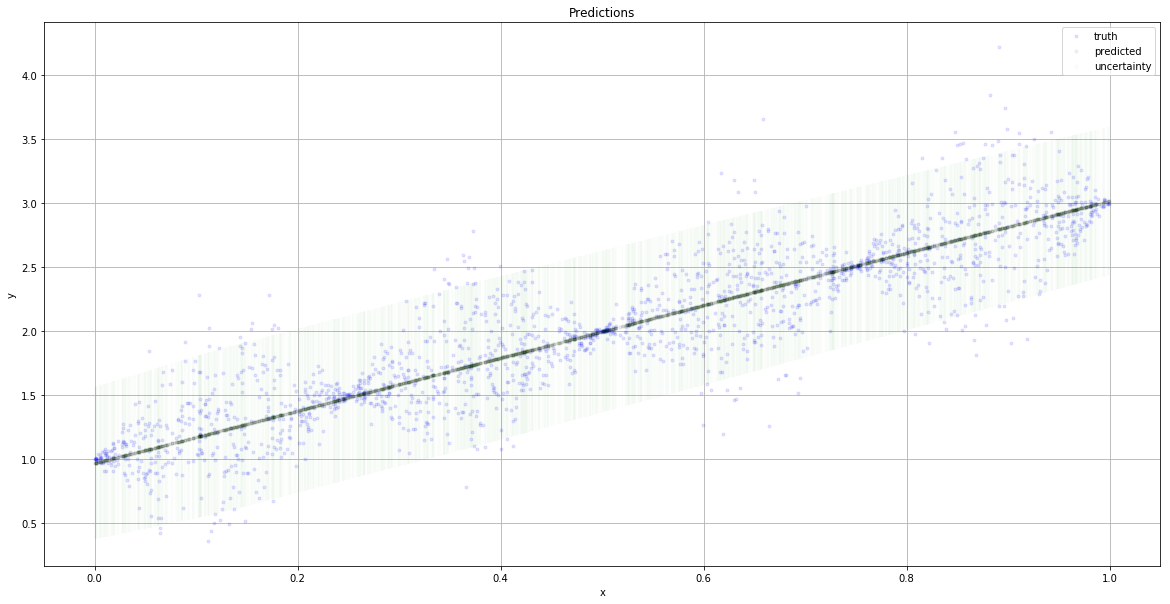

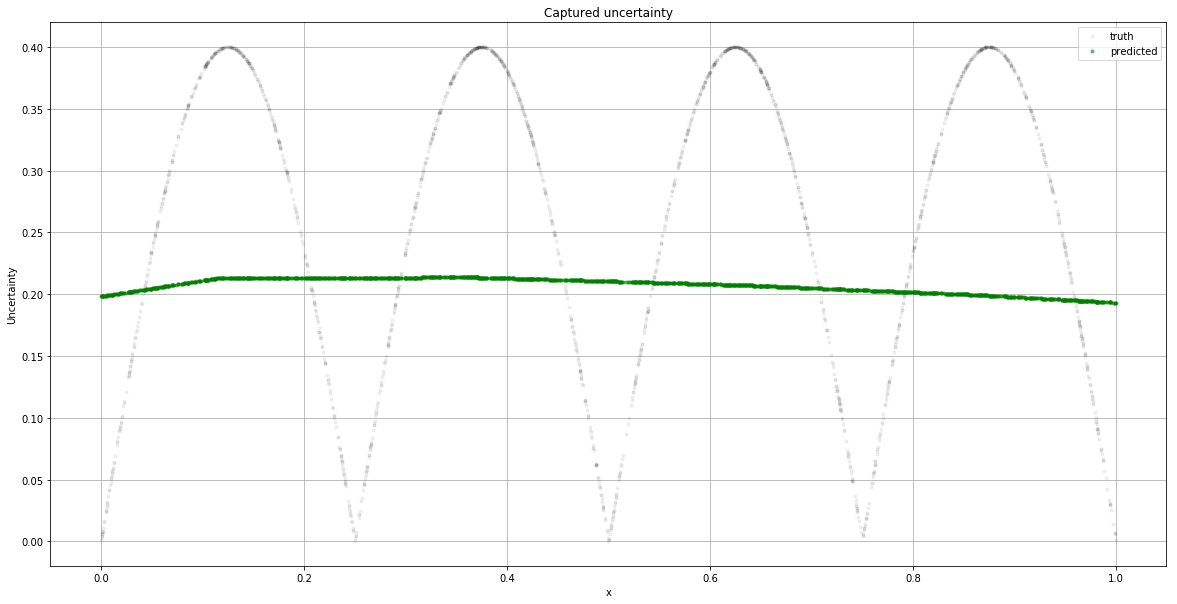

In [31]:
print_metrics(experiment['model'], experiment['loss'], test_x, test_y, f_uncertainty=gen_stdev_01)

### Conclusion

I have found **NO EVIDENCE** to say the technique works. The captured standard deviation is homoscedastic, the confidence margins per point are the same all along the dataset.

This causes a disonance because the [original implementation](00-original_pytorch.ipynb) in Pytorch seems to work differently. But, as I have not been able to replicate the behaviour I can't continue that path.

The next figure shows the **captured standard deviation** per point, the shape should resemble the curve we build in the section [Adding uncertainty](#Adding-uncertainty).

## Minibatches <a name="experiment-minibatches"></a>

One thing that could be causing trouble is to use the whole dataset (batch) in a single optimization step. In this experiment I will use a minibatch approach to ease the convergence and test the modelling capabilities.

I start on a copy of the previous experiment.

In [33]:
experiment = experiments['minibatches'] = {
    'name': '02-minibatches',
    'data': experiments['original']['data'].copy(),
    'hyper': experiments['original']['hyper'].copy(),
    'loss': experiments['original']['loss'],
    'model': get_model_01()  # Start with a fresh model
}

experiment['hyper']['optimizer'] = tf.keras.optimizers.Adam(  # Start with a fresh optimizer
    learning_rate=1e-4,
)

### Changes

I will use a smaller batch size and I will train for more epochs.

**Note**

At first I trained the model for the same number of epochs and tracked the evolution of the **std dev curve**, I saw it resembled the [original one](#Considerations) so I trained for a longer number of epochs until the model was properly fit.

In [40]:
experiment['hyper']['bs'] = 512  # Reduce the batch size to ease the convergence
experiment['hyper']['epochs'] *= 5

### Model

#### Train

Epoch: 0	Loss: 8.442192077636719
Loss: 8.237634658813477


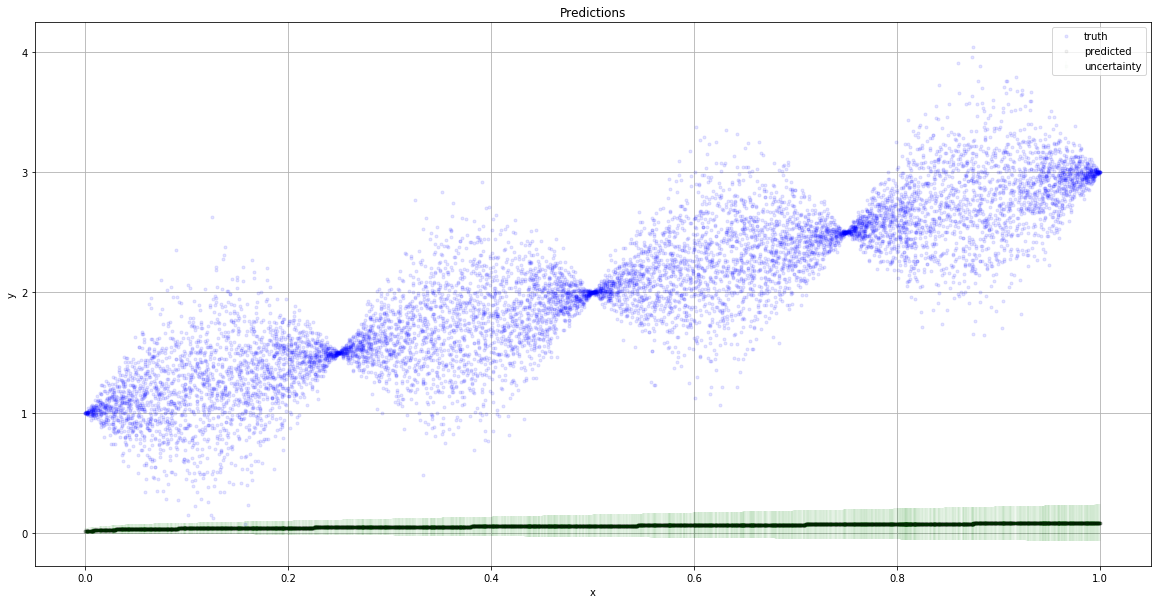

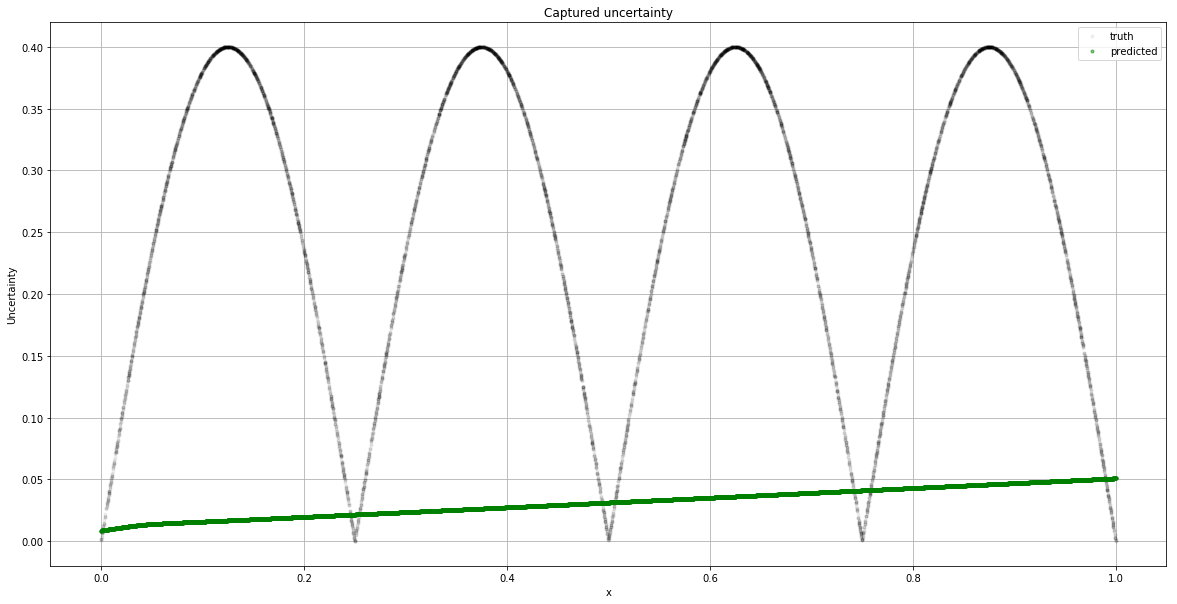

Epoch: 100	Loss: 0.12949880957603455
Epoch: 200	Loss: 0.12747475504875183
Epoch: 300	Loss: 0.1293543577194214
Epoch: 400	Loss: 0.09355631470680237
Epoch: 500	Loss: 0.12381219863891602
Epoch: 600	Loss: 0.11577153950929642
Epoch: 700	Loss: 0.13914576172828674
Epoch: 800	Loss: 0.12616367638111115
Epoch: 900	Loss: 0.11540159583091736
Epoch: 1000	Loss: 0.13802385330200195
Epoch: 1100	Loss: 0.1197935938835144
Epoch: 1200	Loss: 0.10029644519090652
Epoch: 1300	Loss: 0.1270437240600586
Epoch: 1400	Loss: 0.13006919622421265
Epoch: 1500	Loss: 0.12018119543790817
Epoch: 1600	Loss: 0.13526268303394318
Epoch: 1700	Loss: 0.13278010487556458
Epoch: 1800	Loss: 0.10478188097476959
Epoch: 1900	Loss: 0.11438267678022385
Epoch: 2000	Loss: 0.11269424855709076
Epoch: 2100	Loss: 0.100034698843956
Epoch: 2200	Loss: 0.11540067940950394
Epoch: 2300	Loss: 0.09560192376375198
Epoch: 2400	Loss: 0.11832127720117569
Epoch: 2500	Loss: 0.10219433903694153
Epoch: 2600	Loss: 0.10679683834314346
Epoch: 2700	Loss: 0.126581

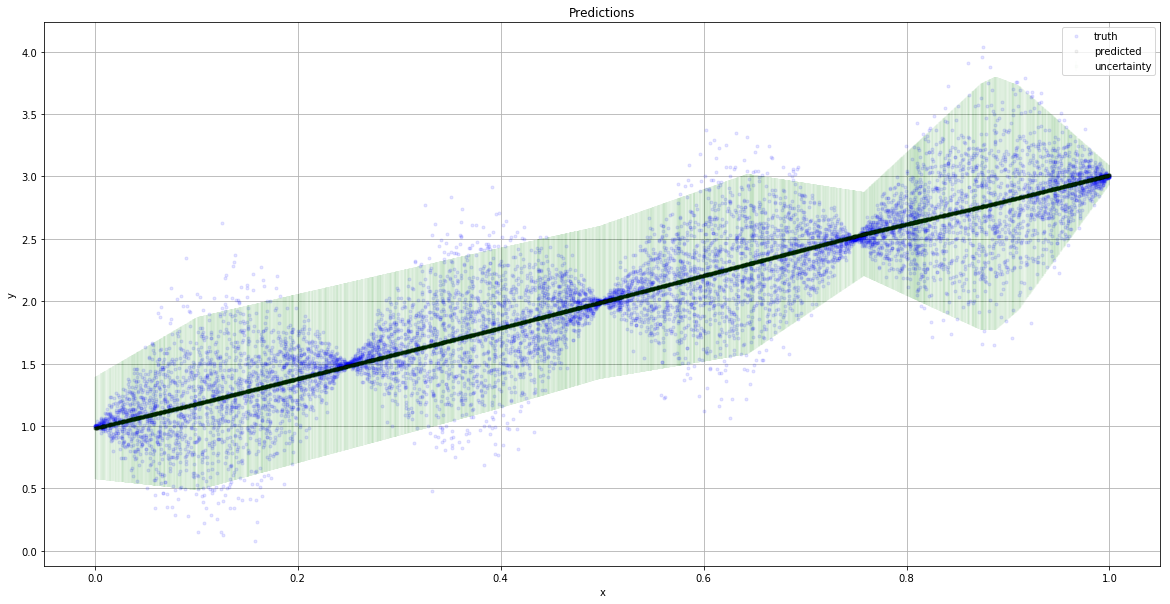

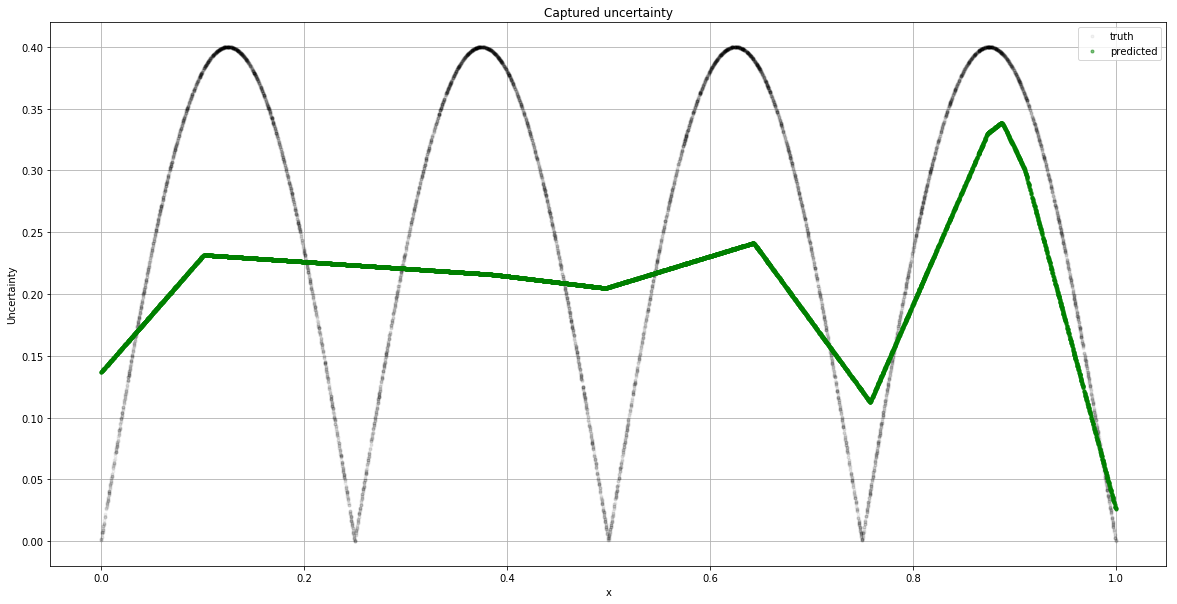

Epoch: 3100	Loss: 0.1400105506181717
Epoch: 3200	Loss: 0.11724445223808289
Epoch: 3300	Loss: 0.10685554146766663
Epoch: 3400	Loss: 0.1246894970536232
Epoch: 3500	Loss: 0.1506263017654419
Epoch: 3600	Loss: 0.12659241259098053
Epoch: 3700	Loss: 0.10305697470903397
Epoch: 3800	Loss: 0.14636476337909698
Epoch: 3900	Loss: 0.12463658303022385
Epoch: 4000	Loss: 0.11200748383998871
Epoch: 4100	Loss: 0.12404176592826843
Epoch: 4200	Loss: 0.11115336418151855
Epoch: 4300	Loss: 0.10719705373048782
Epoch: 4400	Loss: 0.14242339134216309
Epoch: 4500	Loss: 0.12040191888809204
Epoch: 4600	Loss: 0.1136283278465271
Epoch: 4700	Loss: 0.12414322048425674
Epoch: 4800	Loss: 0.10527113080024719
Epoch: 4900	Loss: 0.12053659558296204
Epoch: 5000	Loss: 0.1256534606218338
Epoch: 5100	Loss: 0.10616148263216019
Epoch: 5200	Loss: 0.1331053376197815
Epoch: 5300	Loss: 0.11231182515621185
Epoch: 5400	Loss: 0.12392865866422653
Epoch: 5500	Loss: 0.09697893261909485
Epoch: 5600	Loss: 0.09689817577600479
Epoch: 5700	Loss: 

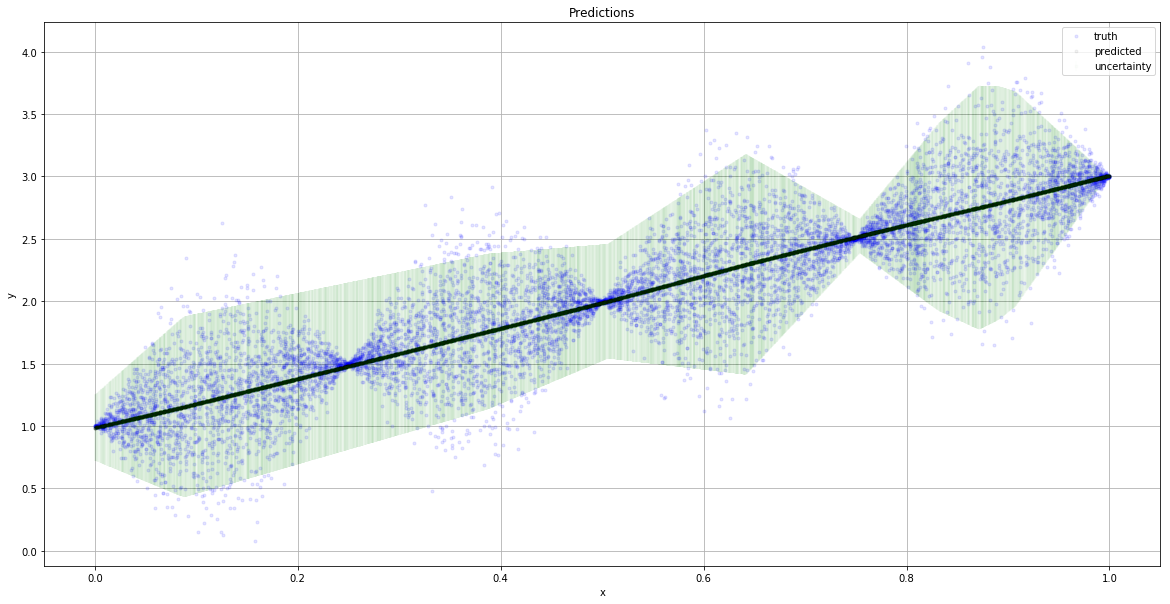

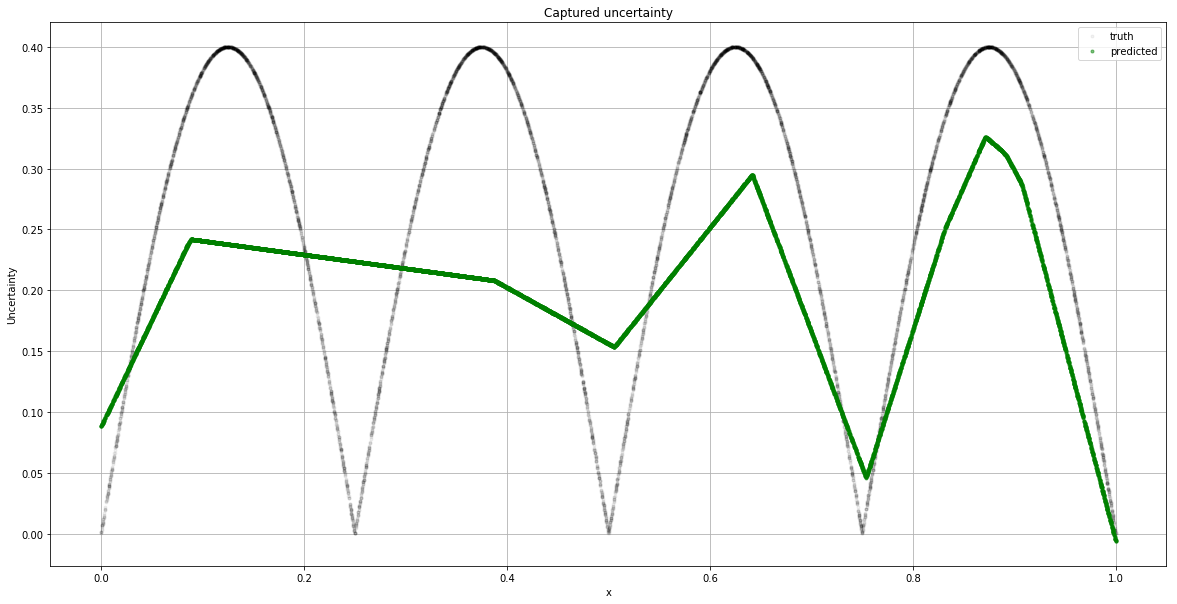

Epoch: 6100	Loss: 0.11381902545690536
Epoch: 6200	Loss: 0.11956631392240524
Epoch: 6300	Loss: 0.12057611346244812
Epoch: 6400	Loss: 0.12599273025989532
Epoch: 6500	Loss: 0.09955579787492752
Epoch: 6600	Loss: 0.11475826799869537
Epoch: 6700	Loss: 0.13239242136478424
Epoch: 6800	Loss: 0.13484783470630646
Epoch: 6900	Loss: 0.09165605157613754
Epoch: 7000	Loss: 0.12032254785299301
Epoch: 7100	Loss: 0.10049722343683243
Epoch: 7200	Loss: 0.1242062896490097
Epoch: 7300	Loss: 0.12887999415397644
Epoch: 7400	Loss: 0.10475204885005951
Epoch: 7500	Loss: 0.10967341810464859
Epoch: 7600	Loss: 0.1142902672290802
Epoch: 7700	Loss: 0.1301388442516327
Epoch: 7800	Loss: 0.12367750704288483
Epoch: 7900	Loss: 0.15193474292755127
Epoch: 8000	Loss: 0.12287086248397827
Epoch: 8100	Loss: 0.0971062034368515
Epoch: 8200	Loss: 0.10532107949256897
Epoch: 8300	Loss: 0.12107516825199127
Epoch: 8400	Loss: 0.10369986295700073
Epoch: 8500	Loss: 0.13122019171714783
Epoch: 8600	Loss: 0.10685063898563385
Epoch: 8700	Loss

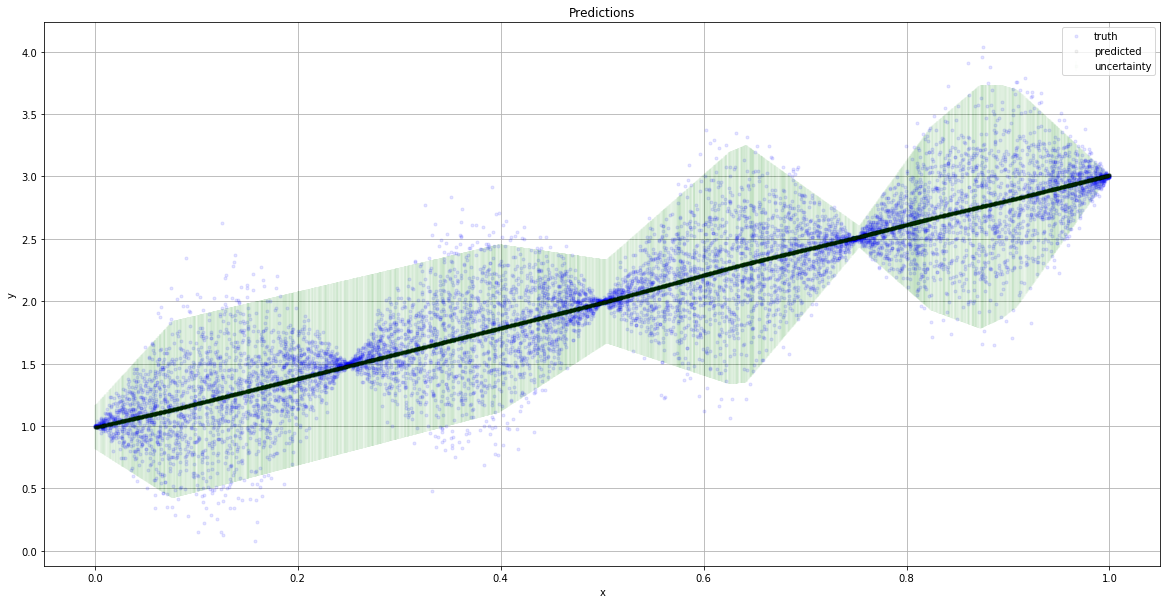

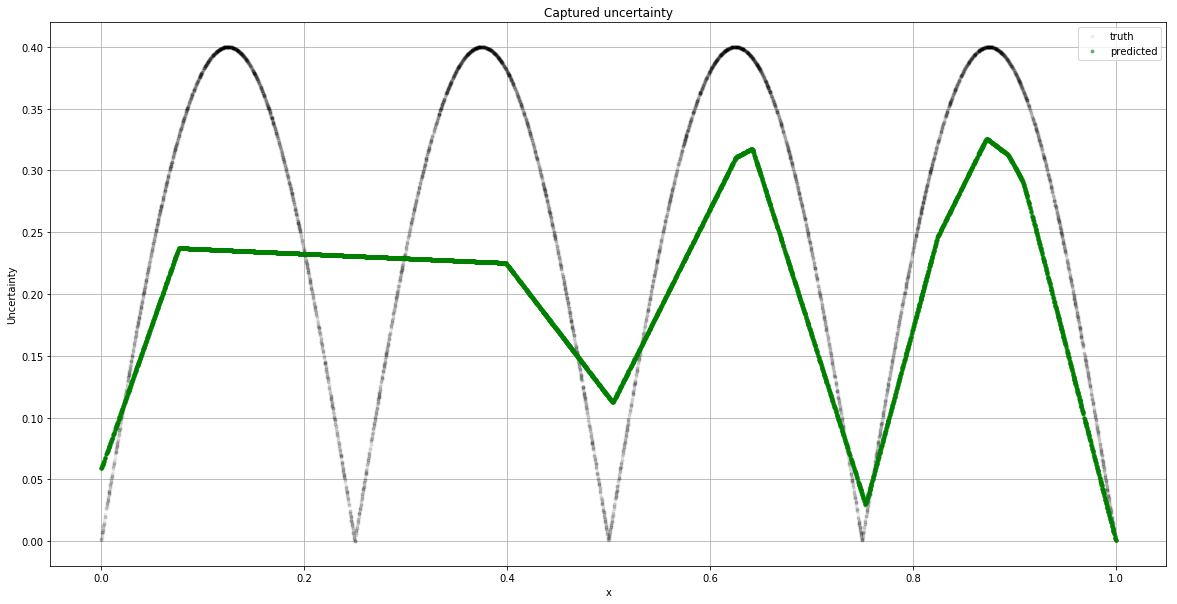

Epoch: 9100	Loss: 0.10614843666553497
Epoch: 9200	Loss: 0.13000284135341644
Epoch: 9300	Loss: 0.12152085453271866
Epoch: 9400	Loss: 0.13748253881931305
Epoch: 9500	Loss: 0.1188497245311737
Epoch: 9600	Loss: 0.13183557987213135
Epoch: 9700	Loss: 0.11097671836614609
Epoch: 9800	Loss: 0.14057064056396484
Epoch: 9900	Loss: 0.10042201727628708
Epoch: 10000	Loss: 0.11749372631311417
Epoch: 10100	Loss: 0.10365190356969833
Epoch: 10200	Loss: 0.11857209354639053
Epoch: 10300	Loss: 0.1129942387342453
Epoch: 10400	Loss: 0.11842285841703415
Epoch: 10500	Loss: 0.10735388845205307
Epoch: 10600	Loss: 0.11675101518630981
Epoch: 10700	Loss: 0.12015261501073837
Epoch: 10800	Loss: 0.123183473944664
Epoch: 10900	Loss: 0.12441542744636536
Epoch: 11000	Loss: 0.10742492228746414
Epoch: 11100	Loss: 0.15171782672405243
Epoch: 11200	Loss: 0.10016705095767975
Epoch: 11300	Loss: 0.11523812264204025
Epoch: 11400	Loss: 0.1179196834564209
Epoch: 11500	Loss: 0.12762588262557983
Epoch: 11600	Loss: 0.1283002644777298
E

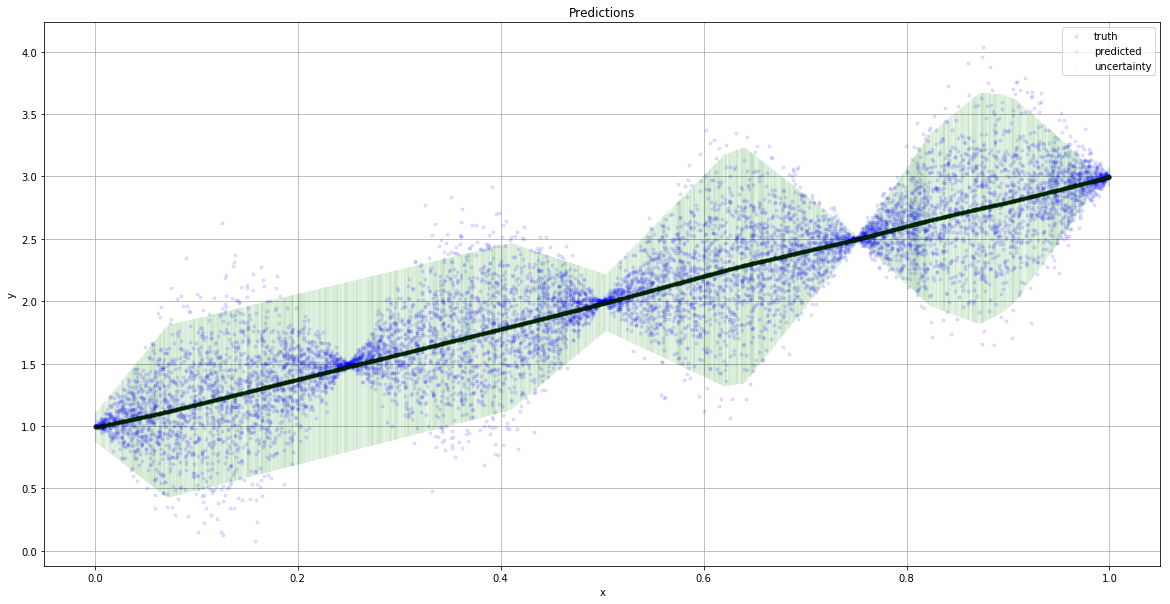

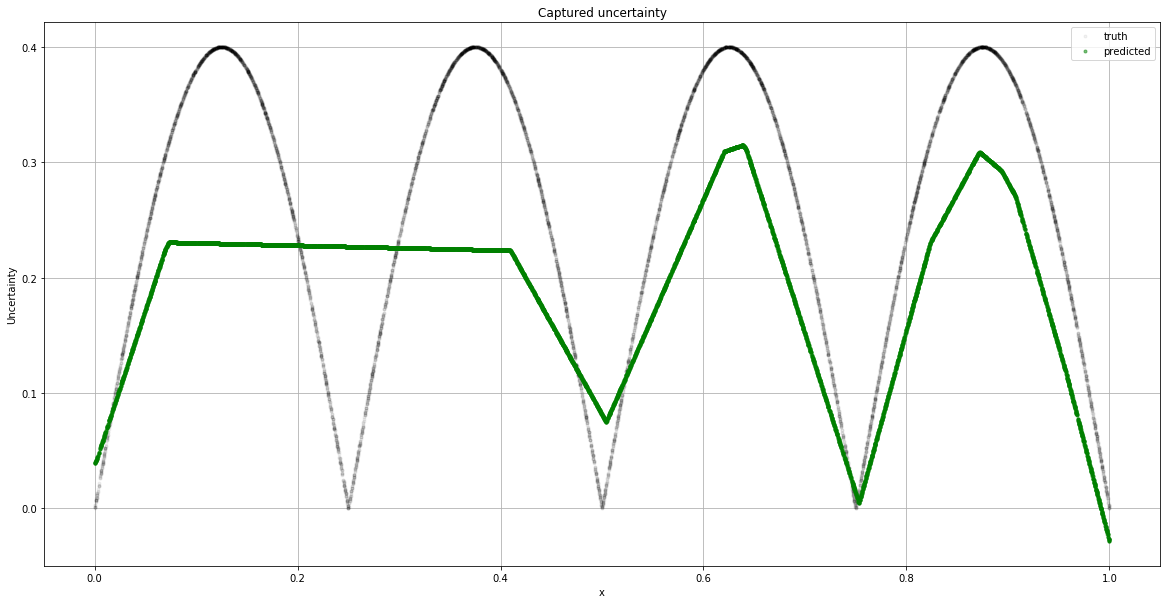

Epoch: 12100	Loss: 0.11458887904882431
Epoch: 12200	Loss: 0.11432477831840515
Epoch: 12300	Loss: 0.09477287530899048
Epoch: 12400	Loss: 0.09645117074251175
Epoch: 12500	Loss: 0.10750359296798706
Epoch: 12600	Loss: 0.09683811664581299
Epoch: 12700	Loss: 0.1099642738699913
Epoch: 12800	Loss: 0.14210401475429535
Epoch: 12900	Loss: 0.13417068123817444
Epoch: 13000	Loss: 0.15207037329673767
Epoch: 13100	Loss: 0.09768640249967575
Epoch: 13200	Loss: 0.12926362454891205
Epoch: 13300	Loss: 0.13398918509483337
Epoch: 13400	Loss: 0.12370514869689941
Epoch: 13500	Loss: 0.09995876997709274
Epoch: 13600	Loss: 0.10155075043439865
Epoch: 13700	Loss: 0.1254560649394989
Epoch: 13800	Loss: 0.11838828772306442
Epoch: 13900	Loss: 0.12250947952270508
Epoch: 14000	Loss: 0.1278935670852661
Epoch: 14100	Loss: 0.11624585837125778
Epoch: 14200	Loss: 0.11375230550765991
Epoch: 14300	Loss: 0.10602674633264542
Epoch: 14400	Loss: 0.14631223678588867
Epoch: 14500	Loss: 0.11511248350143433
Epoch: 14600	Loss: 0.1039291

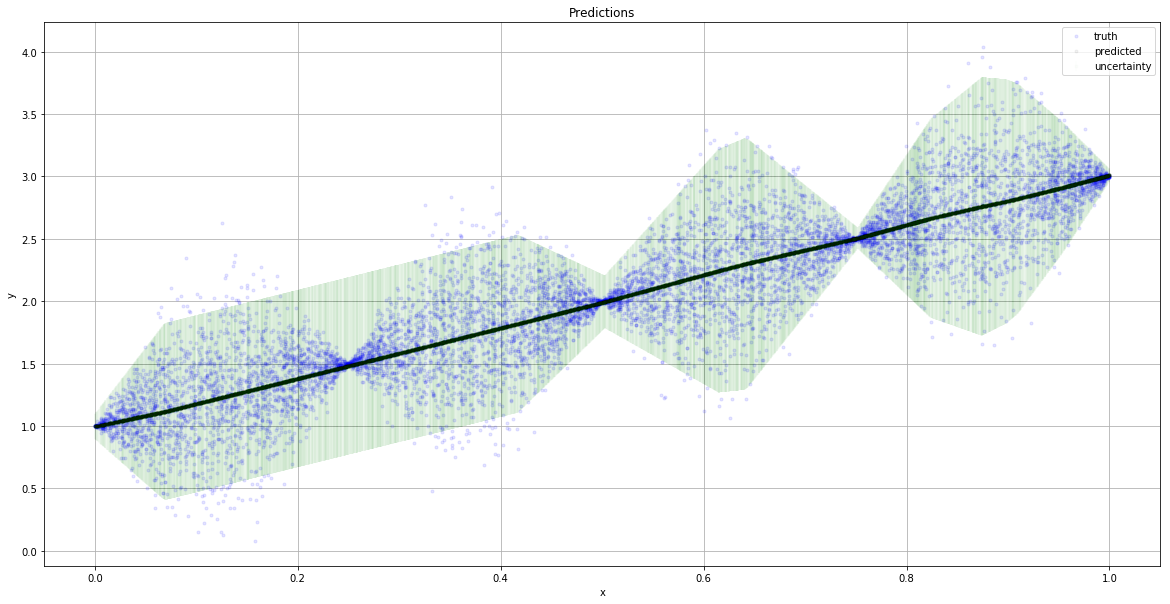

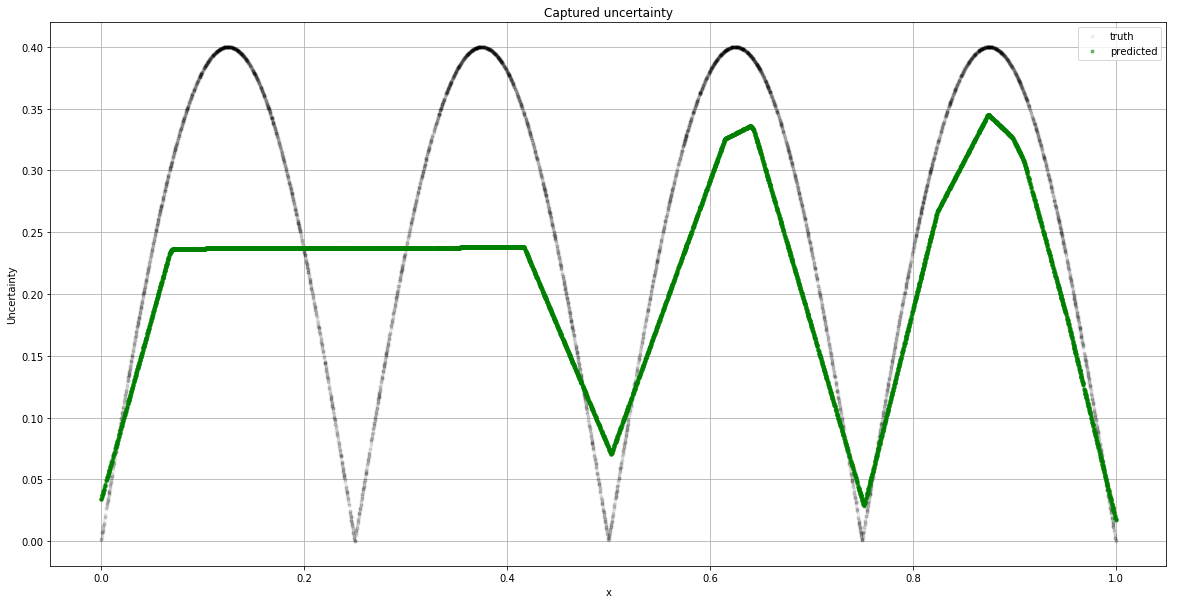

Epoch: 15100	Loss: 0.10558988153934479
Epoch: 15200	Loss: 0.1405365765094757
Epoch: 15300	Loss: 0.13351048529148102
Epoch: 15400	Loss: 0.11077098548412323
Epoch: 15500	Loss: 0.12620340287685394
Epoch: 15600	Loss: 0.11879205703735352
Epoch: 15700	Loss: 0.12978675961494446
Epoch: 15800	Loss: 0.12138306349515915
Epoch: 15900	Loss: 0.10884547978639603
Epoch: 16000	Loss: 0.11285144835710526
Epoch: 16100	Loss: 0.12492948770523071
Epoch: 16200	Loss: 0.13510899245738983
Epoch: 16300	Loss: 0.1130504459142685
Epoch: 16400	Loss: 0.12361501157283783
Epoch: 16500	Loss: 0.10877662897109985
Epoch: 16600	Loss: 0.10546115785837173
Epoch: 16700	Loss: 0.10520375519990921
Epoch: 16800	Loss: 0.11588271707296371
Epoch: 16900	Loss: 0.09113695472478867
Epoch: 17000	Loss: 0.10819512605667114
Epoch: 17100	Loss: 0.08121297508478165
Epoch: 17200	Loss: 0.10573525726795197
Epoch: 17300	Loss: 0.12374060600996017
Epoch: 17400	Loss: 0.09153350442647934
Epoch: 17500	Loss: 0.11625127494335175
Epoch: 17600	Loss: 0.104031

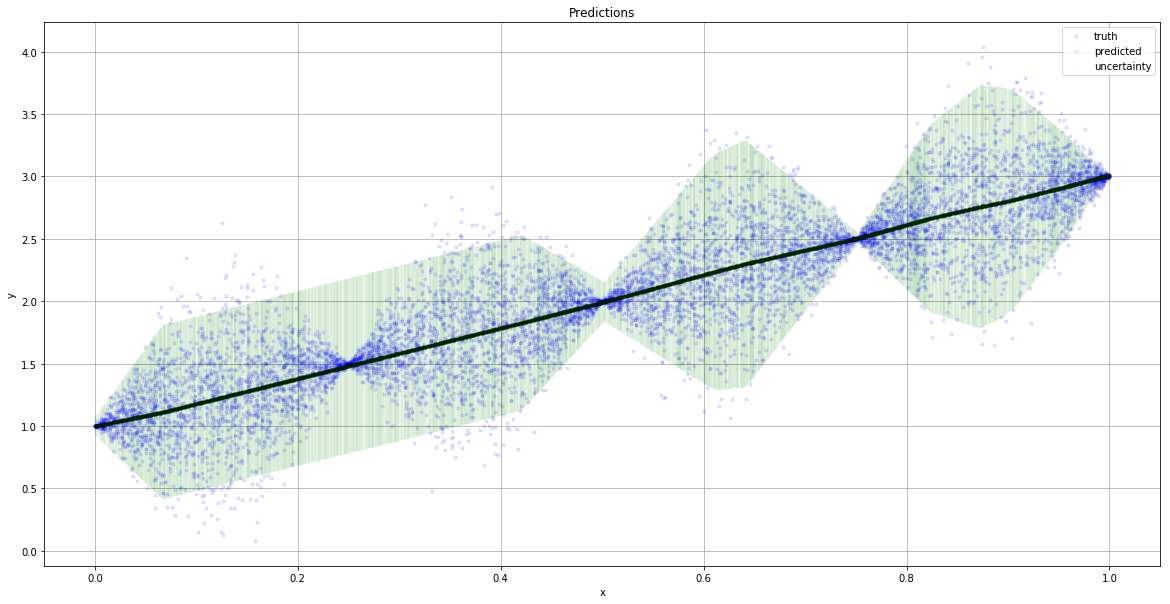

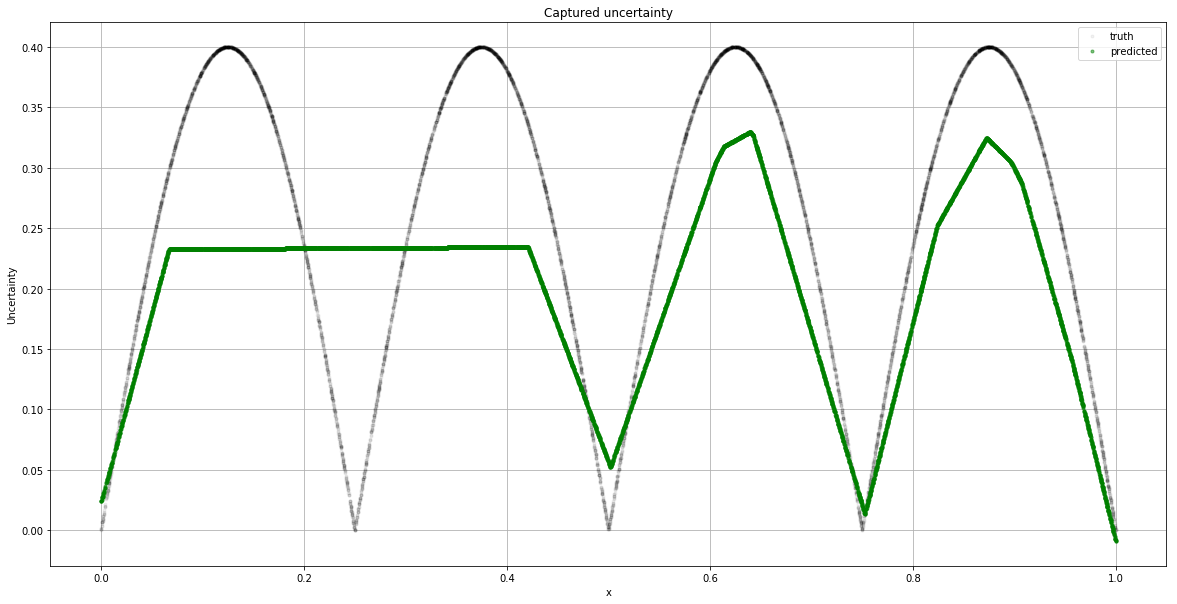

Epoch: 18100	Loss: 0.11619238555431366
Epoch: 18200	Loss: 0.11379262804985046
Epoch: 18300	Loss: 0.14275474846363068
Epoch: 18400	Loss: 0.1382964849472046
Epoch: 18500	Loss: 0.11013001948595047
Epoch: 18600	Loss: 0.1159394159913063
Epoch: 18700	Loss: 0.12305321544408798
Epoch: 18800	Loss: 0.10978057980537415
Epoch: 18900	Loss: 0.11312367022037506
Epoch: 19000	Loss: 0.12469206005334854
Epoch: 19100	Loss: 0.1164911761879921
Epoch: 19200	Loss: 0.11204405874013901
Epoch: 19300	Loss: 0.0851886123418808
Epoch: 19400	Loss: 0.13258586823940277
Epoch: 19500	Loss: 0.11253343522548676
Epoch: 19600	Loss: 0.14817434549331665
Epoch: 19700	Loss: 0.13750118017196655
Epoch: 19800	Loss: 0.11154329776763916
Epoch: 19900	Loss: 0.11017781496047974
Epoch: 20000	Loss: 0.12879730761051178
Epoch: 20100	Loss: 0.10088957101106644
Epoch: 20200	Loss: 0.09506978839635849
Epoch: 20300	Loss: 0.11900199204683304
Epoch: 20400	Loss: 0.1246330589056015
Epoch: 20500	Loss: 0.10156618803739548
Epoch: 20600	Loss: 0.135423660

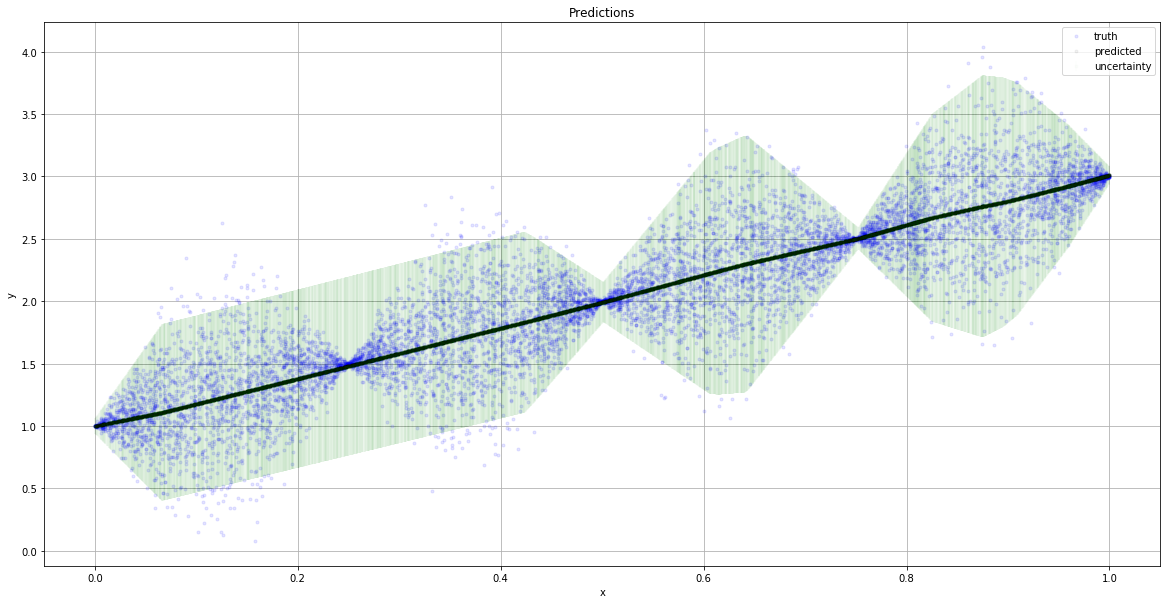

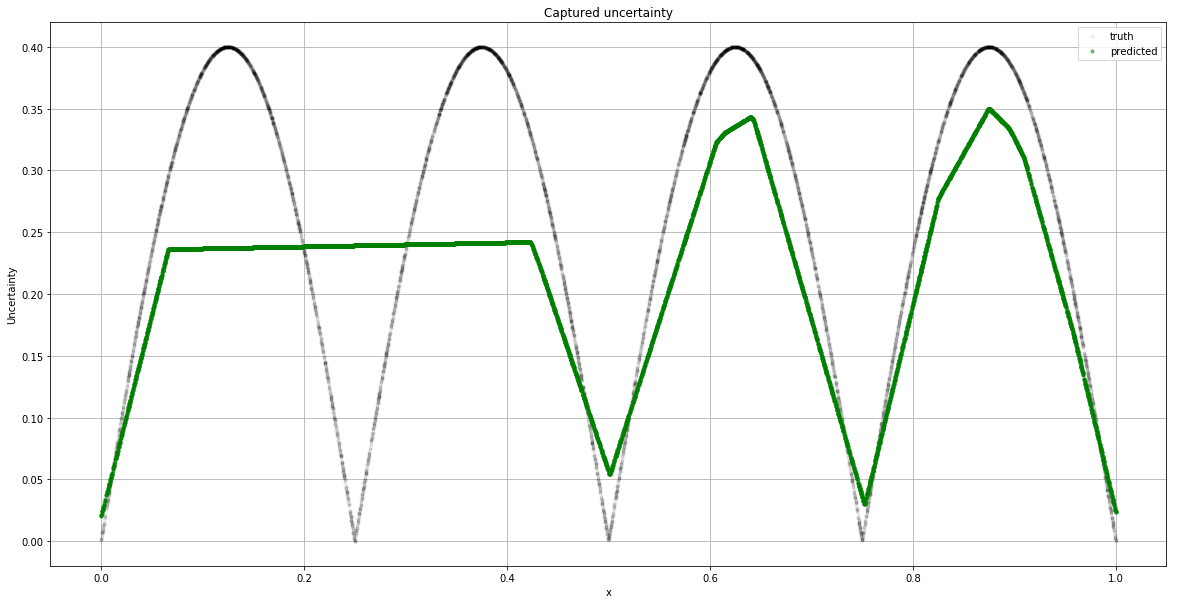

Epoch: 21100	Loss: 0.11508363485336304
Epoch: 21200	Loss: 0.09906861931085587
Epoch: 21300	Loss: 0.12798070907592773
Epoch: 21400	Loss: 0.11419747024774551
Epoch: 21500	Loss: 0.10805242508649826
Epoch: 21600	Loss: 0.11986233294010162
Epoch: 21700	Loss: 0.12368480116128922
Epoch: 21800	Loss: 0.12341316789388657
Epoch: 21900	Loss: 0.11249090731143951
Epoch: 22000	Loss: 0.1280541718006134
Epoch: 22100	Loss: 0.11909566074609756
Epoch: 22200	Loss: 0.1051034927368164
Epoch: 22300	Loss: 0.12805575132369995
Epoch: 22400	Loss: 0.1301090270280838
Epoch: 22500	Loss: 0.11092019826173782
Epoch: 22600	Loss: 0.1296391785144806
Epoch: 22700	Loss: 0.11276517063379288
Epoch: 22800	Loss: 0.14724263548851013
Epoch: 22900	Loss: 0.12208706885576248
Epoch: 23000	Loss: 0.10868443548679352
Epoch: 23100	Loss: 0.12251099199056625
Epoch: 23200	Loss: 0.1011807769536972
Epoch: 23300	Loss: 0.11231648176908493
Epoch: 23400	Loss: 0.12653224170207977
Epoch: 23500	Loss: 0.09848971664905548
Epoch: 23600	Loss: 0.109844304

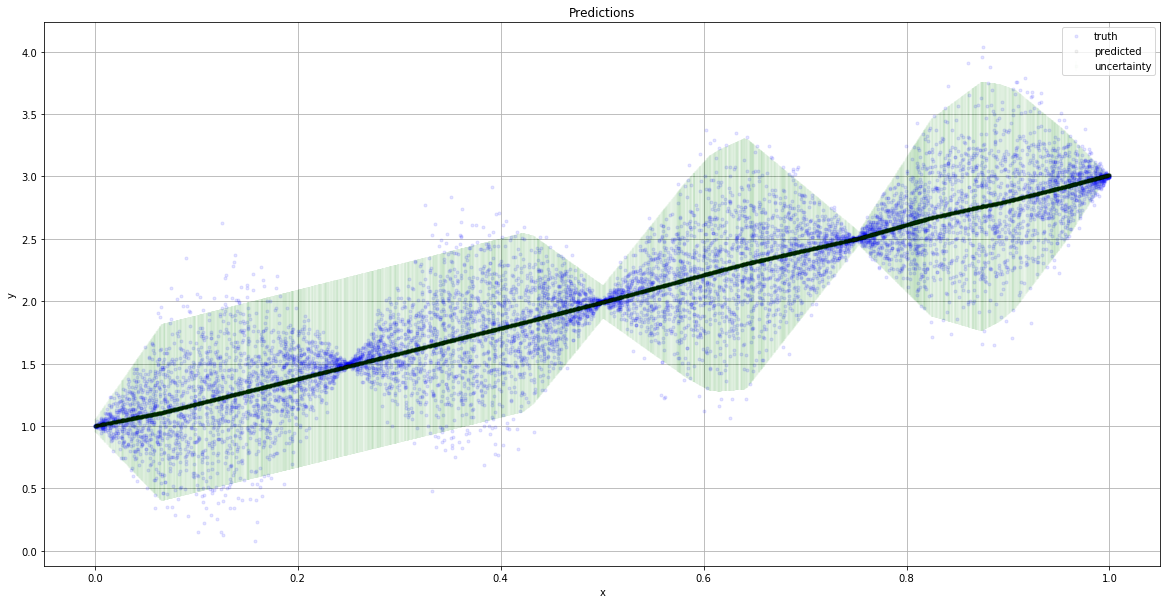

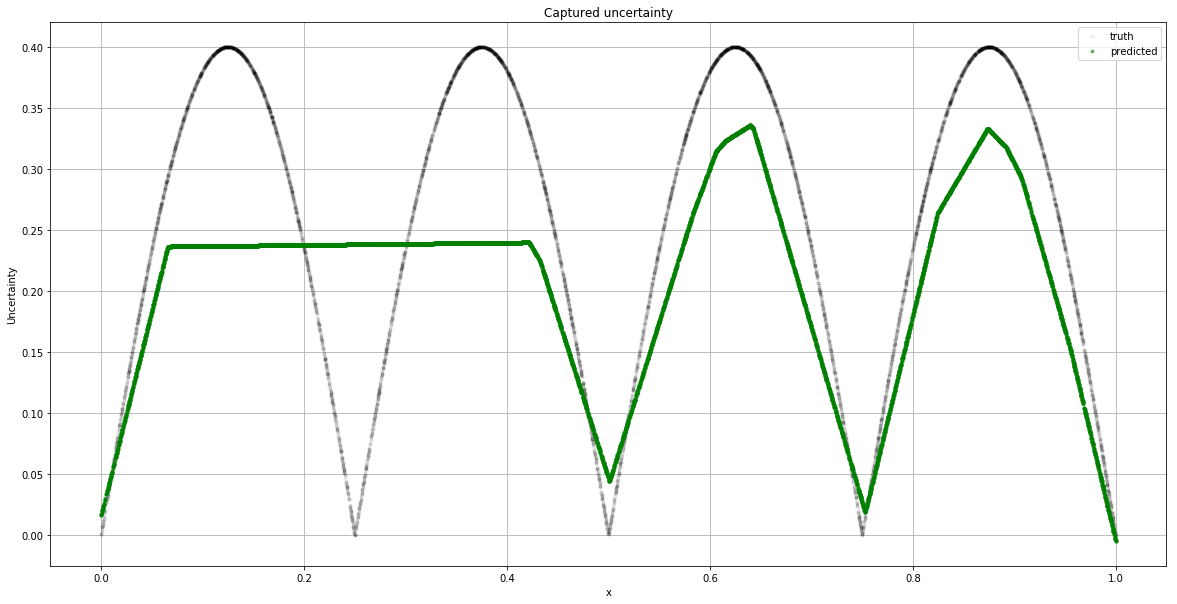

Epoch: 24100	Loss: 0.1103152185678482
Epoch: 24200	Loss: 0.12453802675008774
Epoch: 24300	Loss: 0.11447742581367493
Epoch: 24400	Loss: 0.11173482984304428
Epoch: 24500	Loss: 0.10401331633329391
Epoch: 24600	Loss: 0.14006859064102173
Epoch: 24700	Loss: 0.11697686463594437
Epoch: 24800	Loss: 0.10707003623247147
Epoch: 24900	Loss: 0.12141329795122147
Epoch: 25000	Loss: 0.10404446721076965
Epoch: 25100	Loss: 0.12419573217630386
Epoch: 25200	Loss: 0.11661362648010254
Epoch: 25300	Loss: 0.12655457854270935
Epoch: 25400	Loss: 0.1063053086400032
Epoch: 25500	Loss: 0.12113481760025024
Epoch: 25600	Loss: 0.11260370910167694
Epoch: 25700	Loss: 0.11885873228311539
Epoch: 25800	Loss: 0.10790783911943436
Epoch: 25900	Loss: 0.13540883362293243
Epoch: 26000	Loss: 0.10325814038515091
Epoch: 26100	Loss: 0.11840176582336426
Epoch: 26200	Loss: 0.12606261670589447
Epoch: 26300	Loss: 0.09769394248723984
Epoch: 26400	Loss: 0.10498946905136108
Epoch: 26500	Loss: 0.12784716486930847
Epoch: 26600	Loss: 0.131137

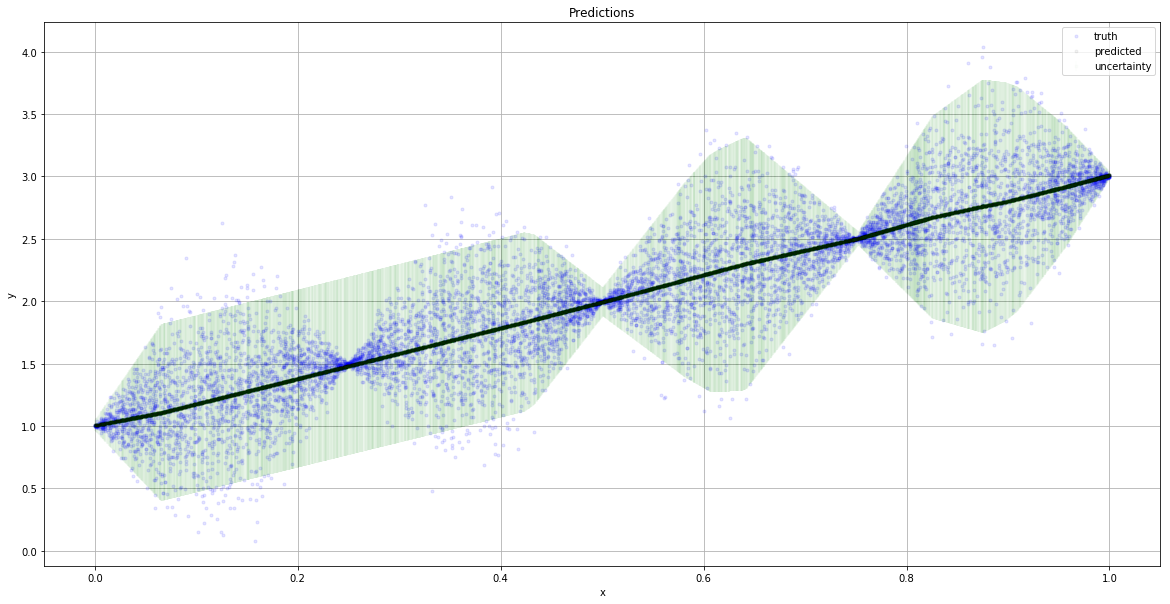

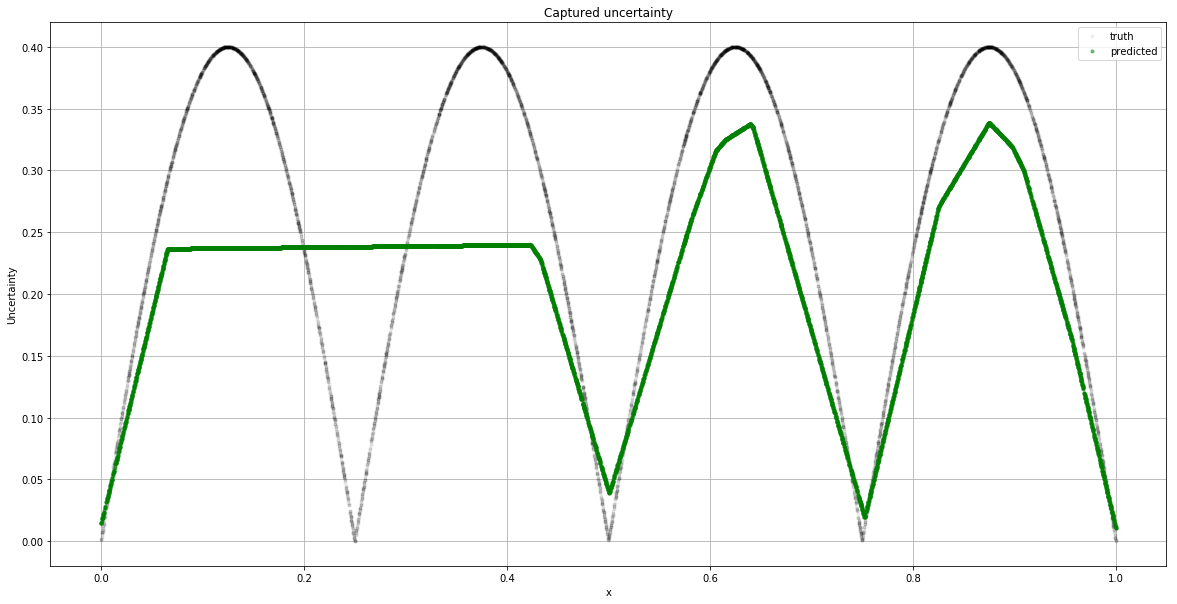

Epoch: 27100	Loss: 0.1152169480919838
Epoch: 27200	Loss: 0.10967706143856049
Epoch: 27300	Loss: 0.07962734252214432
Epoch: 27400	Loss: 0.1232057586312294
Epoch: 27500	Loss: 0.11256382614374161
Epoch: 27600	Loss: 0.09463855624198914
Epoch: 27700	Loss: 0.11450281739234924
Epoch: 27800	Loss: 0.10330956429243088
Epoch: 27900	Loss: 0.12071473151445389
Epoch: 28000	Loss: 0.11485712230205536
Epoch: 28100	Loss: 0.11798591911792755
Epoch: 28200	Loss: 0.12530481815338135
Epoch: 28300	Loss: 0.11607713997364044
Epoch: 28400	Loss: 0.10618770122528076
Epoch: 28500	Loss: 0.1134239062666893
Epoch: 28600	Loss: 0.09810785204172134
Epoch: 28700	Loss: 0.10355986654758453
Epoch: 28800	Loss: 0.11191736906766891
Epoch: 28900	Loss: 0.1158100813627243
Epoch: 29000	Loss: 0.11493699252605438
Epoch: 29100	Loss: 0.12299370765686035
Epoch: 29200	Loss: 0.12230274081230164
Epoch: 29300	Loss: 0.10235799103975296
Epoch: 29400	Loss: 0.13295190036296844
Epoch: 29500	Loss: 0.09568766504526138
Epoch: 29600	Loss: 0.14064414

In [35]:
train(
    model=experiment['model'],
    f_loss=experiment['loss'],
    optimizer=experiment['hyper']['optimizer'],
    batch_size=experiment['hyper']['bs'],
    epochs=experiment['hyper']['epochs'],
    x_train=train_x,
    y_train=train_y,
    f_callback=f_callback_plot
)

In [36]:
# Save
tf.saved_model.save(experiment['model'], 'models/01-original-'+experiment['name'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/01-original-02-minibatches/assets


#### Tests

##### Training set

Loss: 0.11545495688915253


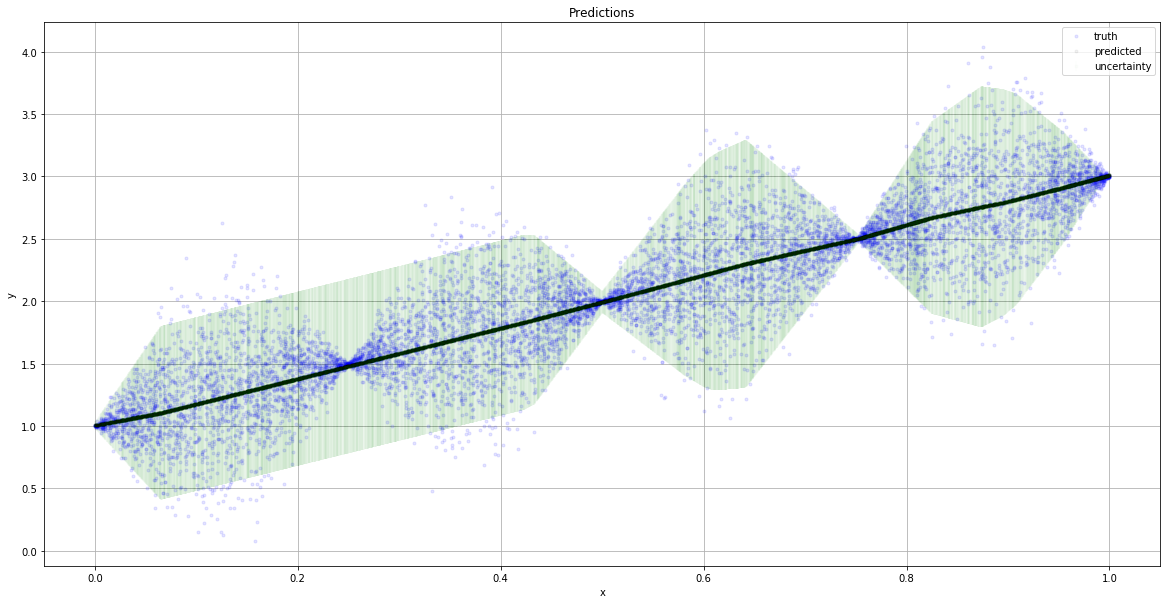

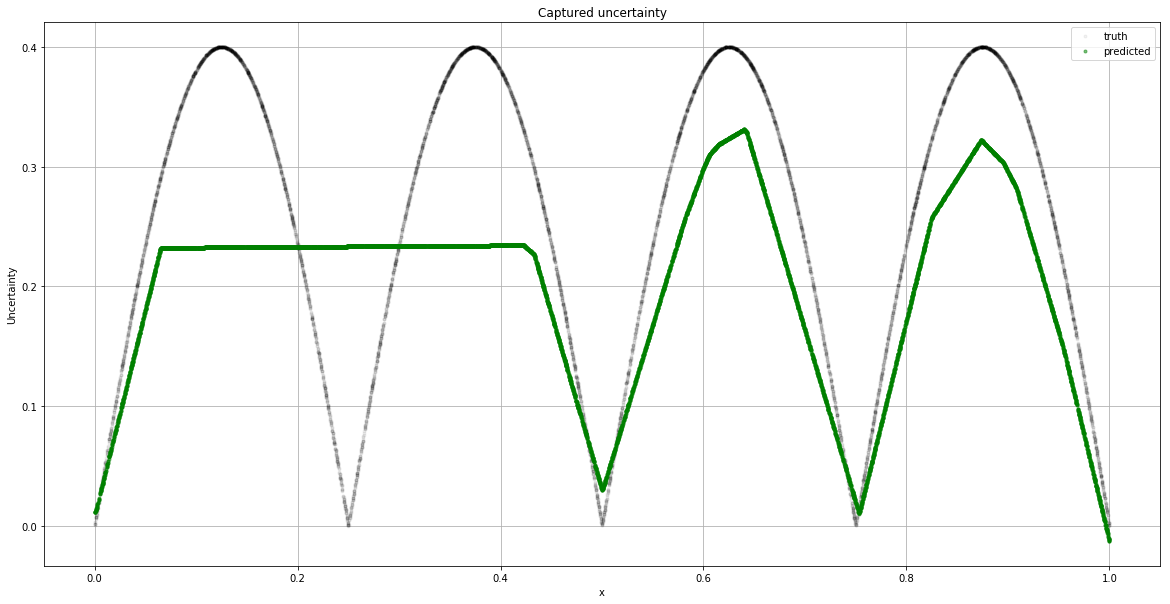

In [37]:
print_metrics(experiment['model'], experiment['loss'], train_x, train_y, f_uncertainty=gen_stdev_01)

##### Testing set

Loss: 0.11598755419254303


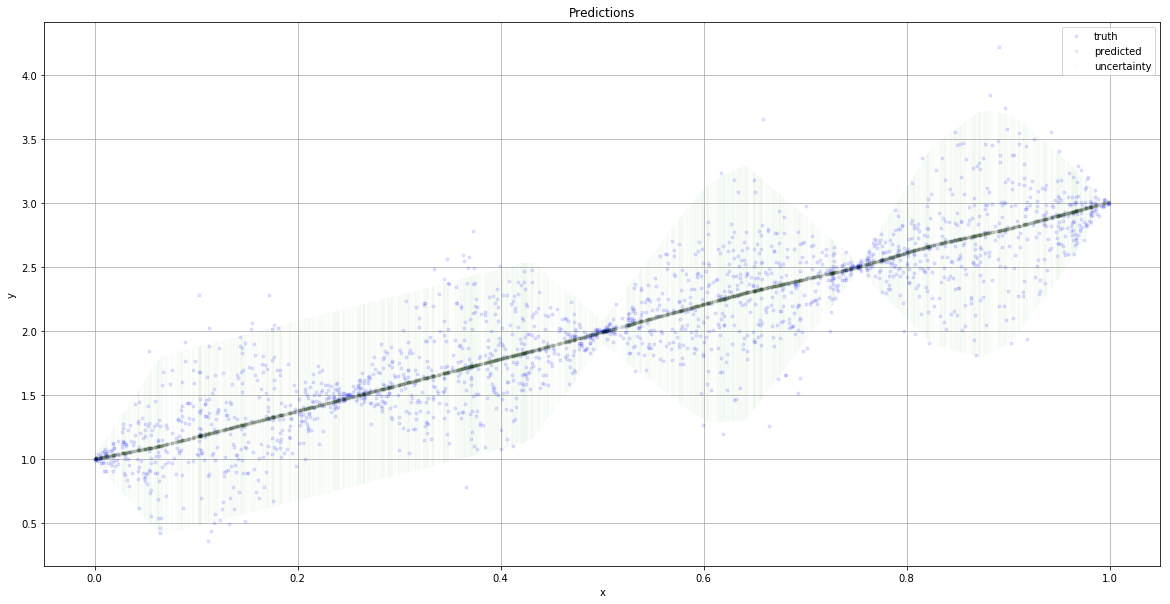

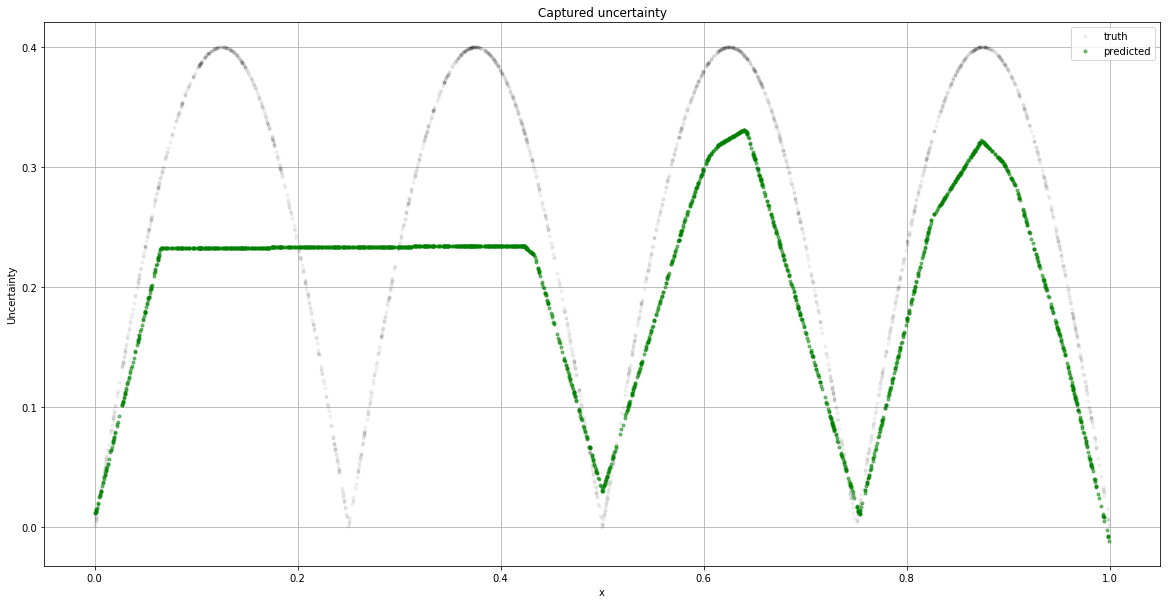

In [38]:
print_metrics(experiment['model'], experiment['loss'], test_x, test_y, gen_stdev_01)

It seems the model has not been able to fully model the uncertainty.

## Conclusion

There are several exposed issues with this method:
1. We had to train for a huge number of epochs 30K.
1. There could be overfitting. We have a lot of free parameters compared to the dataset size.
1. Gradient descent algorithms perfom better with sochastic minibatches.
1. A single loss could dominate the training process.
1. Losses could be antagonic.

The key is that the [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation#Corrected_sample_standard_deviation) is a second [central](https://en.wikipedia.org/wiki/Central_moment#Relation_to_moments_about_the_origin) [moment](https://en.wikipedia.org/wiki/Moment_(mathematics)) magnitude. It means it is derived from the actual prediction and we interpret it as an estimation of the uncertainty for the prediction. So *it makes no sense to fit an error predicion on a bad prediction* (that is what happens while trainning). 

**The on-the-fly method is not a good approach to estimate uncertainty on the predictions.**

There is also other issue. **Estimating the the error prediction can be a problem even bigger than fitting a model to get a good prediction** as we want to know the probability distribution of our predictions (per point). Uncertainty is a derivative of a complex process.

### Future work

Using this knowledge we can propose a 2-step method.
1. Fit a model to get the best prediction.
1. Create another model to estimate the error on the prediction. We could use the first model as an input feature or apply transfer learning to start with a pretrained model which already has modelled useful features.


We hope this propose to solve most of the issues, specially the training time and convergence.

### Bayesian Statistics

This experiment is our first approach to the [bayesian statitics](https://en.wikipedia.org/wiki/Bayesian_statistics) field. We have taken a known problem, curve fitting and we have added a way to estimate the uncertainty in each prediction through [statistical modeling](https://en.wikipedia.org/wiki/Bayesian_statistics#Statistical_modeling). Our prior is to say the error in the estimation will behave like a known distribution with parameters we can estimate.


#### Maximum likelihood estimation VS Maximum Maximum a posteriori estimation

From [Wikipedia - Maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation)


*From the vantage point of Bayesian inference, MLE is a special case of maximum a posteriori estimation (MAP) that assumes a uniform prior distribution of the parameters. In frequentist inference, MLE is a special case of an extremum estimator, with the objective function being the likelihood.*

See also the section ["Relation to Bayesian inference"](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation#Relation_to_Bayesian_inference).

#### Limitations
Of course this is a very naïve approach as the error distribution could have any shape, so a good [design of experiment](https://en.wikipedia.org/wiki/Bayesian_statistics#Design_of_experiments) is a must to get more informed priors.


## List of experiments and hyper-parameters

In [41]:
from pprint import pprint

pprint(experiments)

{'minibatches': {'data': {'f_gen_x': <function gen_x_01 at 0x7f2000575158>,
                          'f_noise': <function f_noise_gaussian_periodic_01 at 0x7f1f8412b488>,
                          'f_x2y': <function relationship_01 at 0x7f1f8624d730>,
                          'n_test': 2000,
                          'n_train': 10000},
                 'hyper': {'bs': 512,
                           'epochs': 30000,
                           'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f1f50607b00>},
                 'loss': <tensorflow.python.eager.def_function.Function object at 0x7f1f863d54a8>,
                 'model': <tensorflow.python.keras.engine.training.Model object at 0x7f1f505fea58>,
                 'name': '02-minibatches'},
 'original': {'data': {'f_gen_x': <function gen_x_01 at 0x7f2000575158>,
                       'f_noise': <function f_noise_gaussian_periodic_01 at 0x7f1f8412b488>,
                       'f_x2y': <function relationshi

## References

### Steve Thorn - Predicting uncertainty with neural networks
* [Medium - Post](https://medium.com/@steve_thorn/predicting-uncertainty-with-neural-networks-aec0217eb37d)
* Jupyter Notebook: [original](https://github.com/sthorn/deep-learning-explorations/blob/master/predicting-uncertainty-variance.ipynb), [local copy](01-Original.ipynb)



###  StatQuest (youtube videos)
* [The Normal Distribution, Clearly Explained!!!](https://www.youtube.com/watch?v=rzFX5NWojp0)
* [Probability vs Likelihood](https://www.youtube.com/watch?v=pYxNSUDSFH4)
* [Maximum Likelihood, clearly explained!!!](https://www.youtube.com/watch?v=Dn6b9fCIUpM)
* [Maximum Likelihood For the Normal Distribution, step-by-step!](https://www.youtube.com/watch?v=Dn6b9fCIUpM)


### TensorFlow
* [Better performance with tf.function](https://www.tensorflow.org/guide/function)